In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/uselssxyz/Padilla - 1 Nobleza virtuosa (1637).pdf
/kaggle/input/ezcarazvozes/Ezcaray - Vozes (1).pdf
/kaggle/input/maskrcnnr101fpn_final/pytorch/default/1/model_final (8).pth


In [2]:
!pip install layoutparser torchvision && pip install "detectron2@git+https://github.com/facebookresearch/detectron2.git@v0.5#egg=detectron2"
!pip install 'git+https://github.com/facebookresearch/detectron2.git@ff53992b1985b63bd3262b5a36167098e3dada02'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 69.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 82.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 32.0 MB/s eta 0:00:00:00:0100:01
   ━━

In [3]:
pip install PyMuPDF

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 71.2 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2 import model_zoo
import fitz  # PyMuPDF
import json
from scipy.spatial.distance import cdist

In [5]:
import os
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import torch

2025-07-30 03:51:59.030956: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753847519.208196      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753847519.258908      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
class TextlineExtractor:
    def __init__(self, model_path):
        self.cfg = self.setup_cfg(model_path)
        self.predictor = DefaultPredictor(self.cfg)
        
        # Initialize TrOCR
        print("Loading TrOCR model...")
        self.trocr_processor = TrOCRProcessor.from_pretrained('qantev/trocr-large-spanish')
        self.trocr_model = VisionEncoderDecoderModel.from_pretrained('qantev/trocr-large-spanish')
        
        # Move to GPU if available
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.trocr_model.to(self.device)
        print(f"TrOCR model loaded on {self.device}")
        
    def setup_cfg(self, model_path):
        cfg = get_cfg()
        cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
        cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # textline, baseline
        cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
        cfg.MODEL.WEIGHTS = model_path
        cfg.DATASETS.TEST = ("page_test",)
        cfg.DATALOADER.NUM_WORKERS = 2
        MetadataCatalog.get("page_test").thing_classes = ["textline", "baseline"]
        return cfg
    
    def pdf_to_images(self, pdf_path, dpi=200):
        """Convert PDF pages to images"""
        doc = fitz.open(pdf_path)
        images = []
        for page_num in range(len(doc)):
            page = doc.load_page(page_num)
            mat = fitz.Matrix(dpi/72, dpi/72)  # Scale factor for DPI
            pix = page.get_pixmap(matrix=mat)
            img_data = pix.tobytes("png")
            # Convert to OpenCV format
            nparr = np.frombuffer(img_data, np.uint8)
            img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
            images.append(img)
        doc.close()
        return images
    
    def calculate_dynamic_padding(self, boxes, image_shape):
        """
        Calculate dynamic padding based on average distances between textboxes
        """
        if len(boxes) < 2:
            # Default padding if too few boxes
            return {"top": 10, "bottom": 10, "left": 8, "right": 8}
        
        # Calculate centers of bounding boxes
        centers = []
        for box in boxes:
            x1, y1, x2, y2 = box
            center_x = (x1 + x2) / 2
            center_y = (y1 + y2) / 2
            centers.append([center_x, center_y])
        
        centers = np.array(centers)
        
        # Calculate vertical distances (between textlines)
        vertical_distances = []
        horizontal_distances = []
        
        # Sort boxes by y-coordinate to find vertical neighbors
        sorted_indices = np.argsort(centers[:, 1])
        sorted_centers = centers[sorted_indices]
        sorted_boxes = boxes[sorted_indices]
        
        # Calculate vertical gaps between consecutive textlines
        for i in range(len(sorted_boxes) - 1):
            current_box = sorted_boxes[i]
            next_box = sorted_boxes[i + 1]
            
            # Check if boxes are roughly horizontally aligned (same column)
            current_center_x = (current_box[0] + current_box[2]) / 2
            next_center_x = (next_box[0] + next_box[2]) / 2
            
            # If horizontally close (within reasonable threshold)
            if abs(current_center_x - next_center_x) < image_shape[1] * 0.3:
                # Calculate vertical gap
                gap = next_box[1] - current_box[3]  # top of next - bottom of current
                if gap > 0:  # Only positive gaps
                    vertical_distances.append(gap)
        
        # Calculate horizontal gaps (between columns)
        for i in range(len(boxes)):
            for j in range(i + 1, len(boxes)):
                box1, box2 = boxes[i], boxes[j]
                
                # Check if boxes are roughly vertically aligned (same row)
                if abs((box1[1] + box1[3])/2 - (box2[1] + box2[3])/2) < (box1[3] - box1[1]) * 0.8:
                    # Calculate horizontal gap
                    if box1[2] < box2[0]:  # box1 is to the left
                        gap = box2[0] - box1[2]
                    elif box2[2] < box1[0]:  # box2 is to the left
                        gap = box1[0] - box2[2]
                    else:
                        continue  # Overlapping boxes
                    
                    if gap > 0:
                        horizontal_distances.append(gap)
        
        # Calculate average distances
        avg_vertical_gap = np.median(vertical_distances) if vertical_distances else 20
        avg_horizontal_gap = np.median(horizontal_distances) if horizontal_distances else 15
        
        # Calculate dynamic padding (half of average gap, with limits)
        vertical_padding = max(5, min(25, avg_vertical_gap / 2))
        horizontal_padding = max(3, min(20, avg_horizontal_gap / 3))
        
        # Also consider box heights for more adaptive padding
        box_heights = [box[3] - box[1] for box in boxes]
        avg_height = np.mean(box_heights)
        
        # Scale padding based on text size
        height_factor = max(0.1, min(0.3, avg_height / 100))
        vertical_padding = max(vertical_padding, avg_height * height_factor)
        
        padding = {
            "top": int(vertical_padding * 0.95),     # Less padding on top
            "bottom": int(vertical_padding * 1.2),  # More padding on bottom
            "left": int(horizontal_padding),
            "right": int(horizontal_padding)
        }
        
        print(f"Dynamic padding calculated: {padding}")
        print(f"  - Vertical gaps found: {len(vertical_distances)}, avg: {avg_vertical_gap:.1f}")
        print(f"  - Horizontal gaps found: {len(horizontal_distances)}, avg: {avg_horizontal_gap:.1f}")
        print(f"  - Average text height: {avg_height:.1f}")
        
        return padding

    
    def filter_margin_boxes_by_area(self, boxes, scores, area_threshold_percent=12.5):
        """
        Filter out boxes that are significantly smaller than average (likely marginalia)
        """
        if len(boxes) == 0:
            return np.array([]), np.array([]), np.array([]), np.array([])
        
        # Calculate areas
        areas = []
        for box in boxes:
            x1, y1, x2, y2 = box
            area = (x2 - x1) * (y2 - y1)
            areas.append(area)
        
        areas = np.array(areas)
        avg_area = np.mean(areas)
        area_threshold = avg_area * (area_threshold_percent / 100.0)
        
        # Filter boxes
        main_boxes = []
        main_scores = []
        margin_boxes = []
        margin_scores = []
        
        for i, (box, score, area) in enumerate(zip(boxes, scores, areas)):
            if area >= area_threshold:
                main_boxes.append(box)
                main_scores.append(score)
            else:
                margin_boxes.append(box)
                margin_scores.append(score)
        
        print(f"Area filtering: avg_area={avg_area:.1f}, threshold={area_threshold:.1f}")
        print(f"Kept {len(main_boxes)} boxes, filtered {len(margin_boxes)} small boxes")
        
        return np.array(main_boxes), np.array(main_scores), np.array(margin_boxes), np.array(margin_scores)
    
    
    def detect_columns_and_sort_reading_order(self, boxes, scores):
        """
        Force single column detection and sort textlines in TOP to BOTTOM order only
        """
        if len(boxes) == 0:
            return boxes, scores, []
        
        # Calculate centers
        centers = []
        for box in boxes:
            x1, y1, x2, y2 = box
            center_x = (x1 + x2) / 2
            center_y = (y1 + y2) / 2
            centers.append([center_x, center_y])
        
        centers = np.array(centers)
        
        # FORCE SINGLE COLUMN - treat all textlines as one column
        print("FORCING SINGLE COLUMN DETECTION")
        print(f"Processing {len(boxes)} textlines as single column")
        
        # Create single column with all indices
        all_indices = np.arange(len(boxes))
        columns = [all_indices]  # Single column containing all textlines
        
        print(f"Single column contains {len(all_indices)} textlines")
        
        # Sort by y-coordinate only (top to bottom)
        y_coords = centers[:, 1]
        y_sort_indices = np.argsort(y_coords)
        
        # Create sorted results
        sorted_boxes = []
        sorted_scores = []
        reading_order = []
        
        print("Sorting textlines TOP-to-BOTTOM:")
        for position, sort_idx in enumerate(y_sort_indices):
            original_idx = sort_idx
            sorted_boxes.append(boxes[original_idx])
            sorted_scores.append(scores[original_idx])
            
            # Record reading order information (all in column 0)
            reading_order.append({
                'original_index': int(original_idx),
                'column': 0,  # Always column 0
                'position_in_column': int(position),
                'reading_order_index': int(position)  # Same as position since single column
            })
            
            y_coord = centers[sort_idx, 1]
            print(f"  Reading order {position}: textline {original_idx} at y={y_coord:.1f}")
        
        print(f"Final reading order: Single column, TOP-to-BOTTOM only")
        
        return np.array(sorted_boxes), np.array(sorted_scores), reading_order
        
    def extract_textlines(self, image):
        """Extract textline predictions from image"""
        outputs = self.predictor(image)
        instances = outputs["instances"].to("cpu")
        
        # Filter for textline class (assuming class 0 is textline)
        textline_mask = instances.pred_classes == 0
        textline_boxes = instances.pred_boxes[textline_mask].tensor.numpy()
        textline_scores = instances.scores[textline_mask].numpy()
        
        return textline_boxes, textline_scores, outputs
        
    def crop_textlines_with_dynamic_padding(self, image, boxes, use_margin_filtering=True):
        """Crop textline regions from image with dynamic padding and area filtering"""
        if len(boxes) == 0:
            return [], [], {}
        
        # Filter by area instead of/in addition to margin position
        if use_margin_filtering:
            main_boxes, main_scores, margin_boxes, margin_scores = self.filter_margin_boxes_by_area(
                boxes, np.ones(len(boxes))
            )
            
            # Calculate padding based on main text boxes only
            if len(main_boxes) > 0:
                padding = self.calculate_dynamic_padding(main_boxes, image.shape)
                boxes_for_cropping = main_boxes
            else:
                padding = self.calculate_dynamic_padding(boxes, image.shape)
                boxes_for_cropping = boxes
        else:
            padding = self.calculate_dynamic_padding(boxes, image.shape)
            boxes_for_cropping = boxes
        
        cropped_textlines = []
        padded_boxes = []
        
        for i, box in enumerate(boxes_for_cropping):
            x1, y1, x2, y2 = box.astype(int)
            
            # Apply dynamic padding
            x1_padded = max(0, x1 - padding["left"])
            y1_padded = max(0, y1 - padding["top"])
            x2_padded = min(image.shape[1], x2 + padding["right"])
            y2_padded = min(image.shape[0], y2 + padding["bottom"])
            
            cropped = image[y1_padded:y2_padded, x1_padded:x2_padded]
            cropped_textlines.append(cropped)
            padded_boxes.append([x1_padded, y1_padded, x2_padded, y2_padded])
        
        return cropped_textlines, padded_boxes, padding
    
    def process_textlines_with_trocr(self, cropped_textlines, reading_order_info):
        """
        Process cropped textlines with TrOCR in sequential reading order
        """
        print(f"Processing {len(cropped_textlines)} textlines with TrOCR...")
        
        # Create list of textlines with their reading order
        textlines_with_order = []
        for i, (textline_crop, ro_info) in enumerate(zip(cropped_textlines, reading_order_info)):
            textlines_with_order.append({
                'crop': textline_crop,
                'reading_order_index': ro_info['reading_order_index'],
                'column': ro_info['column'],
                'position_in_column': ro_info['position_in_column'],
                'original_index': ro_info['original_index']
            })
        
        # Sort by reading order index to ensure sequential processing
        textlines_with_order.sort(key=lambda x: x['reading_order_index'])
        
        # Process textlines in sequential order
        ocr_results = []
        
        for idx, textline_data in enumerate(textlines_with_order):
            try:
                # Convert OpenCV image to PIL Image
                crop_bgr = textline_data['crop']
                crop_rgb = cv2.cvtColor(crop_bgr, cv2.COLOR_BGR2RGB)
                pil_image = Image.fromarray(crop_rgb)
                
                # Process with TrOCR
                pixel_values = self.trocr_processor(images=pil_image, return_tensors="pt").pixel_values
                pixel_values = pixel_values.to(self.device)
                
                # Generate text
                with torch.no_grad():
                    generated_ids = self.trocr_model.generate(pixel_values)
                    generated_text = self.trocr_processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
                
                # Store result with reading order information
                ocr_result = {
                    'reading_order_index': textline_data['reading_order_index'],
                    'column': textline_data['column'],
                    'position_in_column': textline_data['position_in_column'],
                    'original_index': textline_data['original_index'],
                    'text': generated_text.strip(),
                    'confidence': 1.0  # TrOCR doesn't provide confidence scores
                }
                
                ocr_results.append(ocr_result)
                
                # Progress indicator
                if (idx + 1) % 10 == 0 or idx == len(textlines_with_order) - 1:
                    print(f"  Processed {idx + 1}/{len(textlines_with_order)} textlines")
                    
            except Exception as e:
                print(f"Error processing textline {textline_data['reading_order_index']}: {str(e)}")
                # Add empty result to maintain order
                ocr_results.append({
                    'reading_order_index': textline_data['reading_order_index'],
                    'column': textline_data['column'],
                    'position_in_column': textline_data['position_in_column'],
                    'original_index': textline_data['original_index'],
                    'text': '',
                    'confidence': 0.0
                })
        
        # Ensure results are sorted by reading order
        ocr_results.sort(key=lambda x: x['reading_order_index'])
        
        print(f"TrOCR processing complete! Processed {len(ocr_results)} textlines in sequential order.")
        return ocr_results
    
    def save_results_with_ocr(self, page_num, image, boxes, scores, cropped_textlines, padded_boxes, 
                             padding_info, reading_order_info, ocr_results, output_dir):
        """Save page image, textline crops, bounding box data, and OCR results"""
        page_dir = os.path.join(output_dir, f"page_{page_num:03d}")
        os.makedirs(page_dir, exist_ok=True)
        
        # Save original page
        cv2.imwrite(os.path.join(page_dir, "page.png"), image)
        
        # Save cropped textlines
        textlines_dir = os.path.join(page_dir, "textlines")
        os.makedirs(textlines_dir, exist_ok=True)
        
        bbox_data = []
        
        # Create mapping from original position to reading order
        reading_order_map = {}
        for ro_info in reading_order_info:
            reading_order_map[ro_info['original_index']] = ro_info
        
        # Create mapping from reading order to OCR results
        ocr_map = {}
        for ocr_result in ocr_results:
            ocr_map[ocr_result['reading_order_index']] = ocr_result
        
        for i, (original_box, padded_box, score, crop) in enumerate(zip(boxes, padded_boxes, scores, cropped_textlines)):
            # Get reading order info for this textline
            reading_order_data = reading_order_map.get(i, {
                'original_index': i, 
                'column': 0, 
                'position_in_column': i, 
                'reading_order_index': i
            })
            
            # Get OCR result for this textline
            reading_idx = reading_order_data['reading_order_index']
            ocr_result = ocr_map.get(reading_idx, {'text': '', 'confidence': 0.0})
            
            # Save cropped textline with reading order index in filename
            col_idx = reading_order_data['column']
            pos_in_col = reading_order_data['position_in_column']
            
            crop_filename = f"textline_{reading_idx:03d}_col{col_idx}_pos{pos_in_col:02d}.png"
            cv2.imwrite(os.path.join(textlines_dir, crop_filename), crop)
            
            # Convert all numpy types to native Python types for JSON serialization
            original_bbox = [float(x) for x in original_box] if hasattr(original_box, '__iter__') else original_box.tolist()
            padded_bbox = [float(x) for x in padded_box] if isinstance(padded_box, (list, tuple)) else padded_box
            
            # Store bbox data with OCR results
            bbox_data.append({
                "textline_id": int(i),
                "reading_order_index": reading_order_data['reading_order_index'],
                "column": reading_order_data['column'],
                "position_in_column": reading_order_data['position_in_column'],
                "original_bbox": original_bbox,
                "padded_bbox": padded_bbox,
                "score": float(score),
                "crop_filename": crop_filename,
                "ocr_text": ocr_result['text'],
                "ocr_confidence": ocr_result['confidence']
            })
        
        # Sort bbox_data by reading order for JSON output
        bbox_data.sort(key=lambda x: x['reading_order_index'])
        
        # Convert padding info to JSON serializable format
        padding_serializable = {}
        for key, value in padding_info.items():
            if isinstance(value, (np.integer, np.floating)):
                padding_serializable[key] = float(value)
            else:
                padding_serializable[key] = value
        
        # Calculate column statistics
        columns = {}
        for data in bbox_data:
            col = data['column']
            if col not in columns:
                columns[col] = []
            columns[col].append(data['reading_order_index'])
        
        # Create full text in reading order
        full_text_by_reading_order = "\n".join([data['ocr_text'] for data in bbox_data if data['ocr_text'].strip()])
        
        # Create column-wise text
        column_texts = {}
        for data in bbox_data:
            col = data['column']
            if col not in column_texts:
                column_texts[col] = []
            if data['ocr_text'].strip():
                column_texts[col].append(data['ocr_text'])
        
        # Save comprehensive results as JSON
        with open(os.path.join(page_dir, "results.json"), 'w', encoding='utf-8') as f:
            json.dump({
                "page_info": {
                    "page_number": page_num + 1,
                    "total_textlines": len(bbox_data),
                    "total_columns": len(columns),
                    "textlines_with_text": len([d for d in bbox_data if d['ocr_text'].strip()])
                },
                "reading_order_summary": {
                    "description": "LEFT-to-RIGHT columns, then TOP-to-BOTTOM within each column",
                    "column_textline_counts": {f"column_{k}": len(v) for k, v in columns.items()},
                    "column_reading_ranges": {f"column_{k}": f"{min(v)}-{max(v)}" for k, v in columns.items()}
                },
                "padding_applied": padding_serializable,
                "full_text_sequential": full_text_by_reading_order,
                "column_texts": {f"column_{k}": "\n".join(v) for k, v in column_texts.items()},
                "textlines": bbox_data
            }, f, indent=2, ensure_ascii=False)
        
        # Save simple text file in reading order
        with open(os.path.join(page_dir, "text_sequential.txt"), 'w', encoding='utf-8') as f:
            f.write(full_text_by_reading_order)
        
        print(f"Saved {len(bbox_data)} textlines with OCR results in reading order:")
        for col_idx, reading_indices in columns.items():
            text_count = len([d for d in bbox_data if d['column'] == col_idx and d['ocr_text'].strip()])
            print(f"  Column {col_idx}: reading order {min(reading_indices)}-{max(reading_indices)} ({len(reading_indices)} textlines, {text_count} with text)")
        
        return bbox_data
    
    def visualize_page(self, image, boxes, scores, padded_boxes, padding_info, reading_order_info, page_num):
        """Visualize page with single column reading order"""
        fig, axes = plt.subplots(1, 3, figsize=(24, 8))
        
        # Original image with original bboxes and reading order
        img_original = image.copy()
        for i, (box, score, ro_info) in enumerate(zip(boxes, scores, reading_order_info)):
            x1, y1, x2, y2 = box.astype(int)
            
            # Single color since single column
            color = (0, 255, 0)  # Green for all textlines
            
            cv2.rectangle(img_original, (x1, y1), (x2, y2), color, 2)
            cv2.putText(img_original, f"R{ro_info['reading_order_index']}", 
                       (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
        
        axes[0].imshow(cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB))
        axes[0].set_title(f"Page {page_num + 1} - Single Column Reading Order")
        axes[0].axis('off')
        
        # Image with padded bboxes
        img_padded = image.copy()
        for i, (box, score, ro_info) in enumerate(zip(padded_boxes, scores, reading_order_info)):
            x1, y1, x2, y2 = [int(coord) for coord in box]
            
            color = (0, 255, 0)  # Green for all textlines
            
            cv2.rectangle(img_padded, (x1, y1), (x2, y2), color, 2)
            cv2.putText(img_padded, f"R{ro_info['reading_order_index']}", 
                       (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
        
        axes[1].imshow(cv2.cvtColor(img_padded, cv2.COLOR_BGR2RGB))
        axes[1].set_title(f"Page {page_num + 1} - With Dynamic Padding")
        axes[1].axis('off')
        
        # Comparison view
        img_comparison = image.copy()
        for i, (orig_box, pad_box, score, ro_info) in enumerate(zip(boxes, padded_boxes, scores, reading_order_info)):
            # Original box in red
            x1, y1, x2, y2 = orig_box.astype(int)
            cv2.rectangle(img_comparison, (x1, y1), (x2, y2), (0, 0, 255), 1)
            
            # Padded box in green
            x1, y1, x2, y2 = [int(coord) for coord in pad_box]
            cv2.rectangle(img_comparison, (x1, y1), (x2, y2), (0, 255, 0), 2)
            
            cv2.putText(img_comparison, f"R{ro_info['reading_order_index']}", 
                       (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
        
        axes[2].imshow(cv2.cvtColor(img_comparison, cv2.COLOR_BGR2RGB))
        axes[2].set_title(f"Page {page_num + 1} - Comparison (Red=Original, Green=Padded)")
        axes[2].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Print reading order info
        print(f"Applied padding: {padding_info}")
        print(f"Reading order: Single column with {len(reading_order_info)} textlines top-to-bottom")
        
        return len(boxes)
    
    def display_textline_samples_with_ocr(self, cropped_textlines, bbox_data, page_num, max_display=10):
        """Display sample cropped textlines with OCR results"""
        n_textlines = min(len(cropped_textlines), max_display)
        if n_textlines == 0:
            return
            
        cols = min(3, n_textlines)
        rows = (n_textlines + cols - 1) // cols
        
        fig, axes = plt.subplots(rows, cols, figsize=(20, 6*rows))
        
        # Handle different subplot configurations
        if rows == 1 and cols == 1:
            axes = [axes]
        elif rows == 1:
            axes = axes.reshape(1, -1)
        elif cols == 1:
            axes = axes.reshape(-1, 1)
        
        for i in range(n_textlines):
            row, col = i // cols, i % cols
            
            if rows == 1:
                ax = axes[0][col] if cols > 1 else axes[0]
            else:
                ax = axes[row][col] if cols > 1 else axes[row][0]
            
            textline_img = cv2.cvtColor(cropped_textlines[i], cv2.COLOR_BGR2RGB)
            ax.imshow(textline_img)
            
            # Add OCR text as title - simplified for single column
            ocr_text = bbox_data[i]['ocr_text'][:50] + "..." if len(bbox_data[i]['ocr_text']) > 50 else bbox_data[i]['ocr_text']
            reading_order = bbox_data[i]['reading_order_index']
            
            ax.set_title(f"R{reading_order}: {ocr_text}", fontsize=10, wrap=True)
            ax.axis('off')
        
        # Hide unused subplots
        for i in range(n_textlines, rows * cols):
            row, col = i // cols, i % cols
            
            if rows == 1:
                ax = axes[0][col] if cols > 1 else axes[0]
            else:
                ax = axes[row][col] if cols > 1 else axes[row][0]
            ax.axis('off')
        
        plt.suptitle(f"Page {page_num + 1} - Single Column Textlines with OCR Results")
        plt.tight_layout()
        plt.show()

In [7]:
def process_pdf_with_trocr(pdf_path, model_path, output_dir="output", max_pages=200, display_pages=5):
    """Main function to process PDF with enhanced textline extraction, reading order, and TrOCR"""
    import random

    # Create output directory
    os.makedirs(output_dir, exist_ok=True)

    # Initialize extractor
    extractor = TextlineExtractor(model_path)

    # Convert PDF to images
    print(f"Converting PDF: {pdf_path}")
    images = extractor.pdf_to_images(pdf_path)
    print(f"Converted {len(images)} pages")

    # Select random pages for display
    total_pages = min(len(images), max_pages)
    pages_to_display = random.sample(range(total_pages), min(display_pages, total_pages))
    pages_to_display.sort()
    print(f"Will display results for {len(pages_to_display)} random pages: {[p+1 for p in pages_to_display]}")

    # Process each page
    total_textlines = 0
    total_text_lines = 0
    
    # Create summary file
    summary_data = {
        "pdf_info": {
            "pdf_path": pdf_path,
            "total_pages_processed": total_pages,
            "pages_displayed": pages_to_display
        },
        "pages": []
    }

    for page_num in range(total_pages):
        print(f"\n{'='*60}")
        print(f"Processing Page {page_num + 1}/{total_pages}...")
        print(f"{'='*60}")

        image = images[page_num]

        # Extract textlines
        boxes, scores, outputs = extractor.extract_textlines(image)
        print(f"Found {len(boxes)} textlines")

        if len(boxes) == 0:
            print("No textlines detected, skipping...")
            continue

        # Filter by area and sort in reading order
        filtered_boxes, filtered_scores, margin_boxes, margin_scores = extractor.filter_margin_boxes_by_area(boxes, scores)

        if len(filtered_boxes) == 0:
            print("No textlines after area filtering, skipping...")
            continue

        # Sort in reading order
        ordered_boxes, ordered_scores, reading_order_info = extractor.detect_columns_and_sort_reading_order(
            filtered_boxes, filtered_scores
        )

        # Crop textlines with dynamic padding
        cropped_textlines, padded_boxes, padding_info = extractor.crop_textlines_with_dynamic_padding(
            image, ordered_boxes, use_margin_filtering=False  # Already filtered by area
        )

        # Process with TrOCR in sequential order
        ocr_results = extractor.process_textlines_with_trocr(cropped_textlines, reading_order_info)

        # Save results with OCR
        bbox_data = extractor.save_results_with_ocr(page_num, image, ordered_boxes, ordered_scores, 
                                                   cropped_textlines, padded_boxes, padding_info, 
                                                   reading_order_info, ocr_results, output_dir)

        # Count lines with actual text
        page_text_lines = len([d for d in bbox_data if d['ocr_text'].strip()])
        total_text_lines += page_text_lines

        # Add to summary
        page_summary = {
            "page_number": page_num + 1,
            "total_textlines": len(ordered_boxes),
            "textlines_with_text": page_text_lines,
            "columns_detected": len(set(ro['column'] for ro in reading_order_info)),
            "full_text_preview": "\n".join([d['ocr_text'] for d in bbox_data if d['ocr_text'].strip()])[:200] + "..."
        }
        summary_data["pages"].append(page_summary)

        # Print sequential text for this page
        print(f"\nSEQUENTIAL TEXT FOR PAGE {page_num + 1}:")
        print("-" * 50)
        for data in bbox_data:
            if data['ocr_text'].strip():
                print(f"R{data['reading_order_index']:03d} C{data['column']}: {data['ocr_text']}")
        print("-" * 50)

        # Only visualize for selected random pages
        if page_num in pages_to_display:
            print(f"\n📊 DISPLAYING RESULTS FOR PAGE {page_num + 1}")
            n_textlines = extractor.visualize_page(image, ordered_boxes, ordered_scores, padded_boxes, 
                                                 padding_info, reading_order_info, page_num)
            extractor.display_textline_samples_with_ocr(cropped_textlines, bbox_data, page_num)

        total_textlines += len(ordered_boxes)

    # Save overall summary
    summary_data["processing_summary"] = {
        "total_textlines_detected": total_textlines,
        "total_textlines_with_text": total_text_lines,
        "success_rate": f"{(total_text_lines/total_textlines*100):.1f}%" if total_textlines > 0 else "0%"
    }
    
    with open(os.path.join(output_dir, "processing_summary.json"), 'w', encoding='utf-8') as f:
        json.dump(summary_data, f, indent=2, ensure_ascii=False)

    print(f"\n{'='*60}")
    print(f"PROCESSING COMPLETE!")
    print(f"{'='*60}")
    print(f"📄 Total pages processed: {total_pages}")
    print(f"📝 Total textlines detected: {total_textlines}")
    print(f"✅ Total textlines with text: {total_text_lines}")
    print(f"📊 Success rate: {(total_text_lines/total_textlines*100):.1f}%" if total_textlines > 0 else "0%")
    print(f"💾 Results saved in: {output_dir}")
    print(f"🖼️ Displayed results for {len(pages_to_display)} random pages")
    print(f"{'='*60}")



Loading TrOCR model...


preprocessor_config.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/957 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.44G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.44G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/420 [00:00<?, ?B/s]

TrOCR model loaded on cuda
Converting PDF: /kaggle/input/ezcarazvozes/Ezcaray - Vozes (1).pdf
Converted 11 pages
Will display results for 5 random pages: [2, 3, 5, 6, 7]

Processing Page 1/11...


/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Found 23 textlines
Area filtering: avg_area=42865.3, threshold=5358.2
Kept 21 boxes, filtered 2 small boxes
FORCING SINGLE COLUMN DETECTION
Processing 21 textlines as single column
Single column contains 21 textlines
Sorting textlines TOP-to-BOTTOM:
  Reading order 0: textline 0 at y=135.8
  Reading order 1: textline 20 at y=355.4
  Reading order 2: textline 16 at y=440.9
  Reading order 3: textline 5 at y=525.9
  Reading order 4: textline 9 at y=612.3
  Reading order 5: textline 17 at y=694.0
  Reading order 6: textline 4 at y=783.9
  Reading order 7: textline 2 at y=867.8
  Reading order 8: textline 12 at y=949.2
  Reading order 9: textline 3 at y=1033.9
  Reading order 10: textline 8 at y=1118.1
  Reading order 11: textline 18 at y=1201.8
  Reading order 12: textline 11 at y=1285.0
  Reading order 13: textline 19 at y=1368.6
  Reading order 14: textline 6 at y=1453.1
  Reading order 15: textline 7 at y=1536.8
  Reading order 16: textline 15 at y=1619.5
  Reading order 17: textline 1

/usr/local/lib/python3.11/dist-packages/transformers/generation/utils.py:1730: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed in v5. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


  Processed 10/21 textlines
  Processed 20/21 textlines
  Processed 21/21 textlines
TrOCR processing complete! Processed 21 textlines in sequential order.
Saved 21 textlines with OCR results in reading order:
  Column 0: reading order 0-20 (21 textlines, 21 with text)

SEQUENTIAL TEXT FOR PAGE 1:
--------------------------------------------------
R000 C0: SENOR ILVSTRISSIMIO.
R001 C0: y y como en el Cupado en el exercicio
R002 C0: de las 'Milliones' en el
R003 C0: Obifpado de Guadalá-
R004 C0: xara recibi una de V.S.I.
R005 C0: en que me da noticia de
R006 C0: como fu Mageftad ( que Dios guárde)
R007 C0: le avia fervido de honrarme con  la
R008 C0: merced de fú Predicador; y como no
R009 C0: Ic opone la predicación de la Magel
R010 C0: cad a la Apoftolica, tuve por de mi obli
R011 C0: gación admitir el favor, rindiendo a
R012 C0: V.S.I. el agradecimiento.
R013 C0: El Rey mi feñor ( que Dios guarde)
R014 C0: hizo la gracia; mas a V.S.I. le le debe:
R015 C0: que por más frutos, que diera

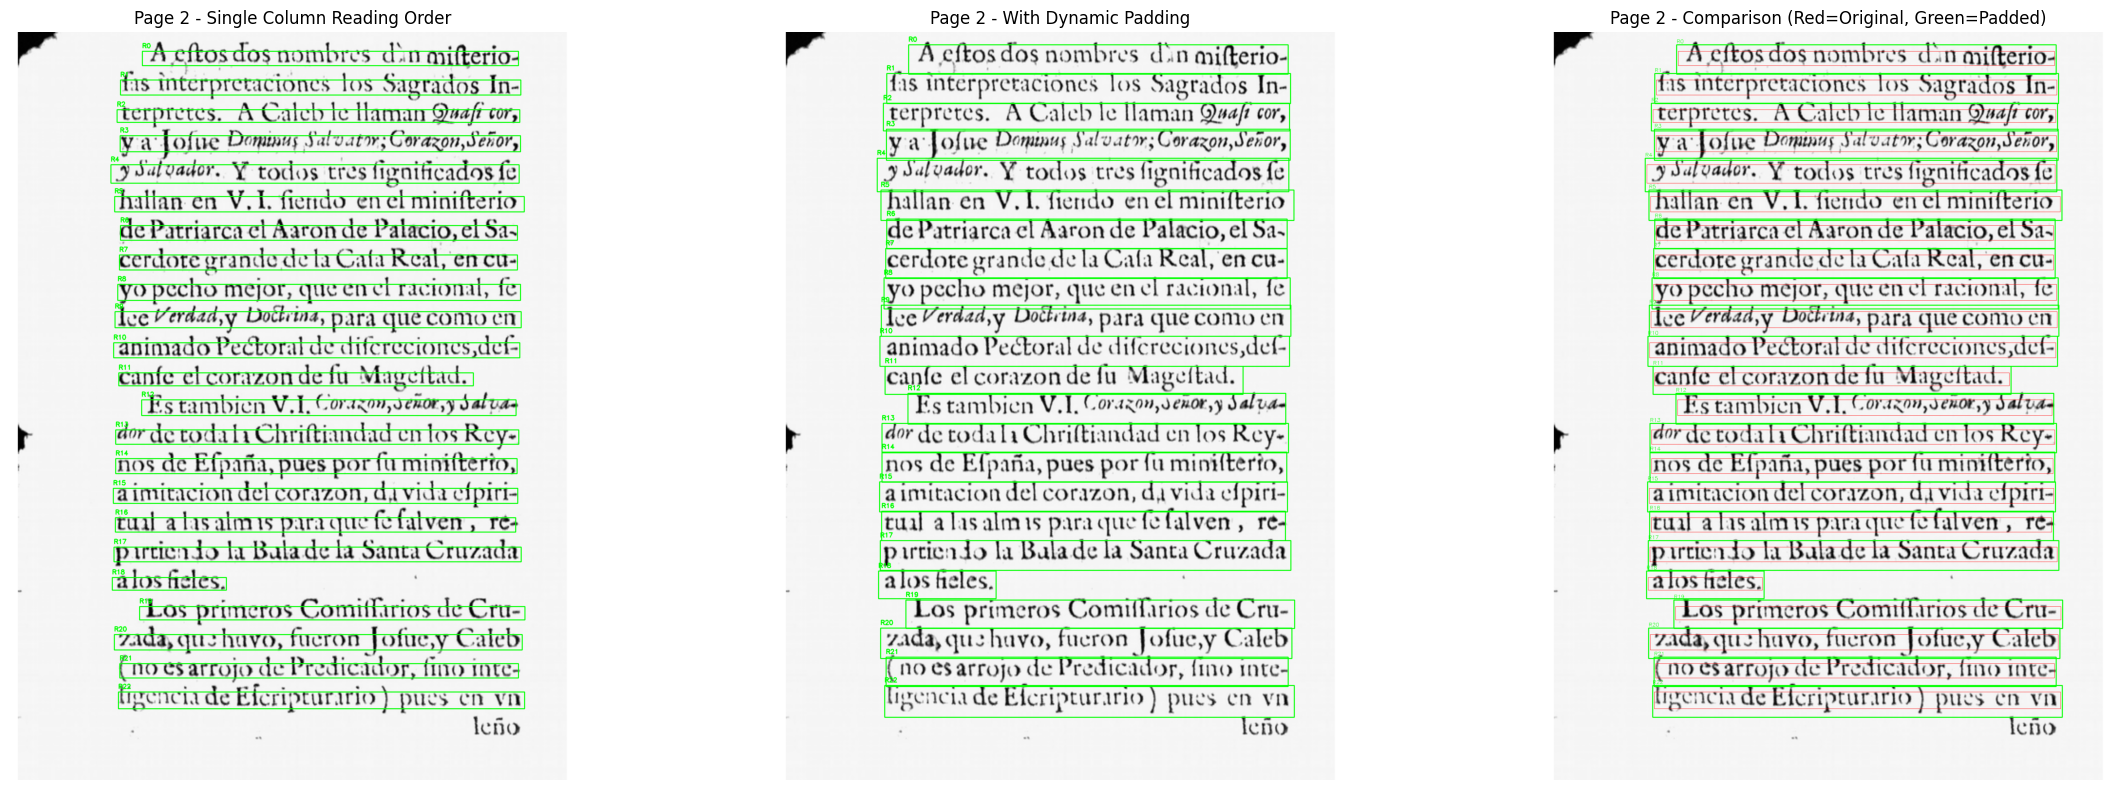

Applied padding: {'top': 19, 'bottom': 25, 'left': 5, 'right': 5}
Reading order: Single column with 23 textlines top-to-bottom


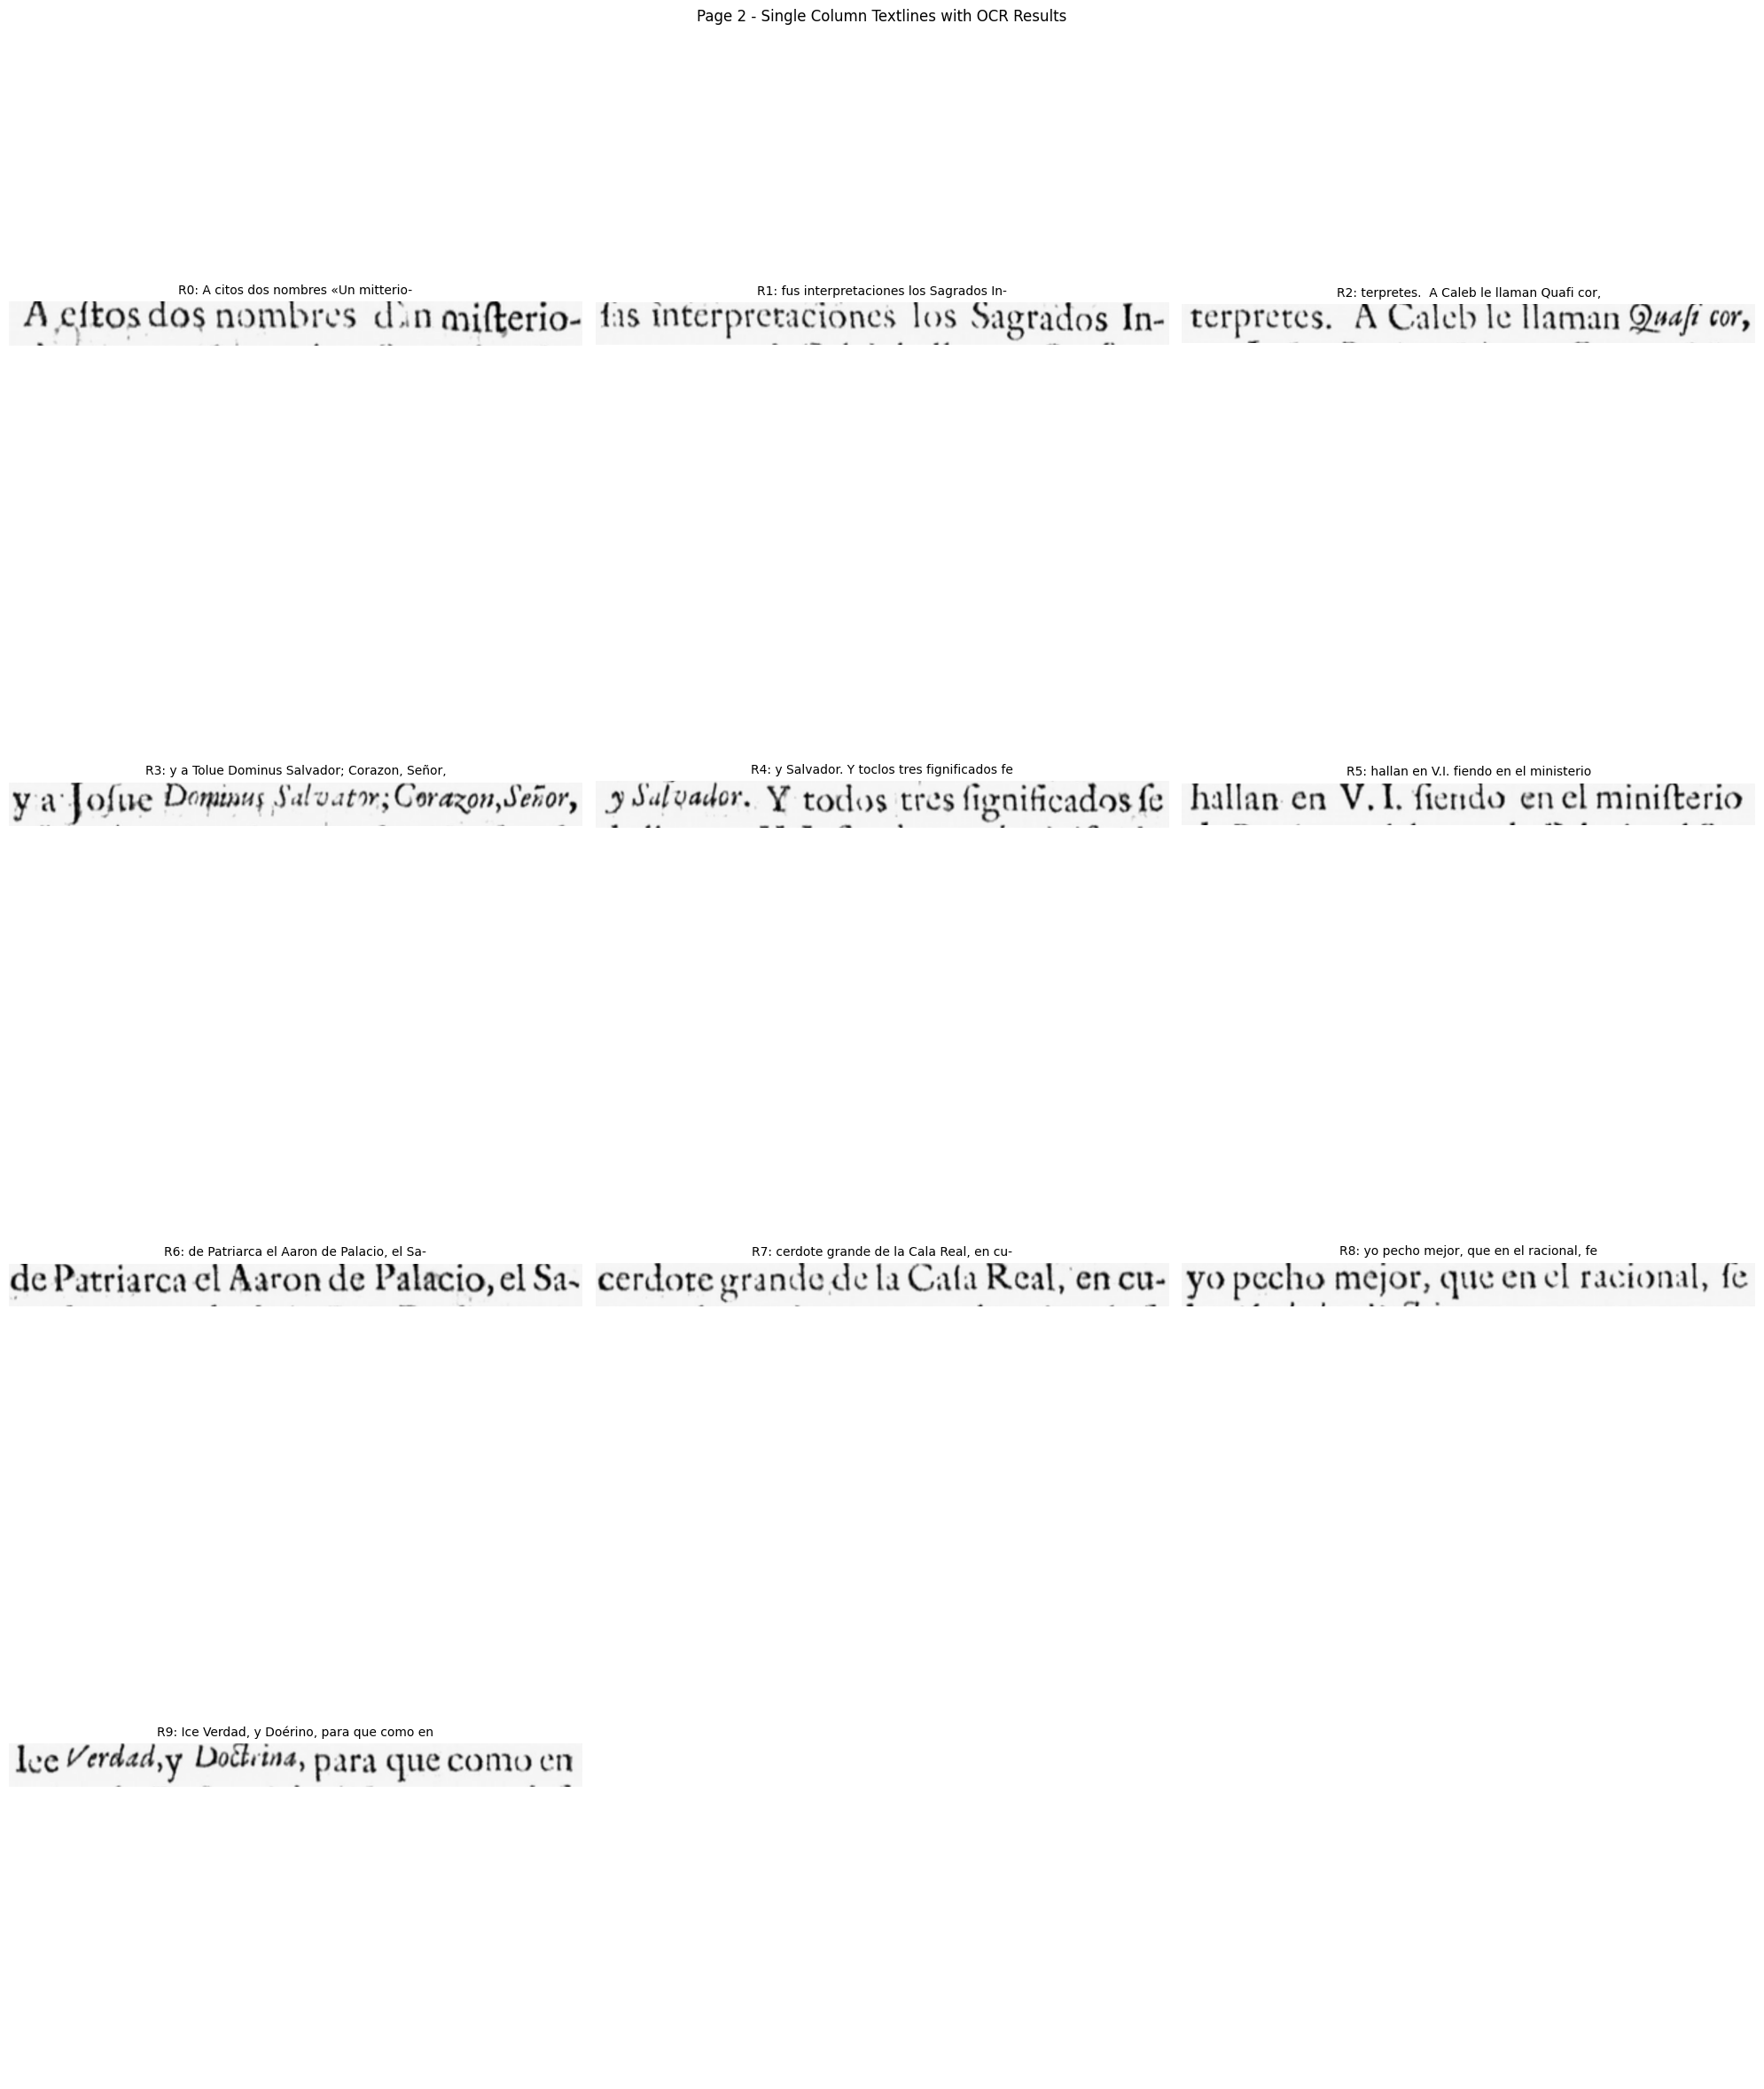


Processing Page 3/11...
Found 25 textlines
Area filtering: avg_area=44185.6, threshold=5523.2
Kept 23 boxes, filtered 2 small boxes
FORCING SINGLE COLUMN DETECTION
Processing 23 textlines as single column
Single column contains 23 textlines
Sorting textlines TOP-to-BOTTOM:
  Reading order 0: textline 19 at y=113.8
  Reading order 1: textline 22 at y=197.2
  Reading order 2: textline 16 at y=283.0
  Reading order 3: textline 12 at y=369.3
  Reading order 4: textline 13 at y=452.3
  Reading order 5: textline 3 at y=536.2
  Reading order 6: textline 14 at y=619.2
  Reading order 7: textline 4 at y=702.8
  Reading order 8: textline 8 at y=787.4
  Reading order 9: textline 2 at y=872.9
  Reading order 10: textline 6 at y=952.5
  Reading order 11: textline 21 at y=1037.4
  Reading order 12: textline 20 at y=1119.0
  Reading order 13: textline 17 at y=1200.3
  Reading order 14: textline 18 at y=1286.5
  Reading order 15: textline 15 at y=1370.4
  Reading order 16: textline 11 at y=1450.3
  R

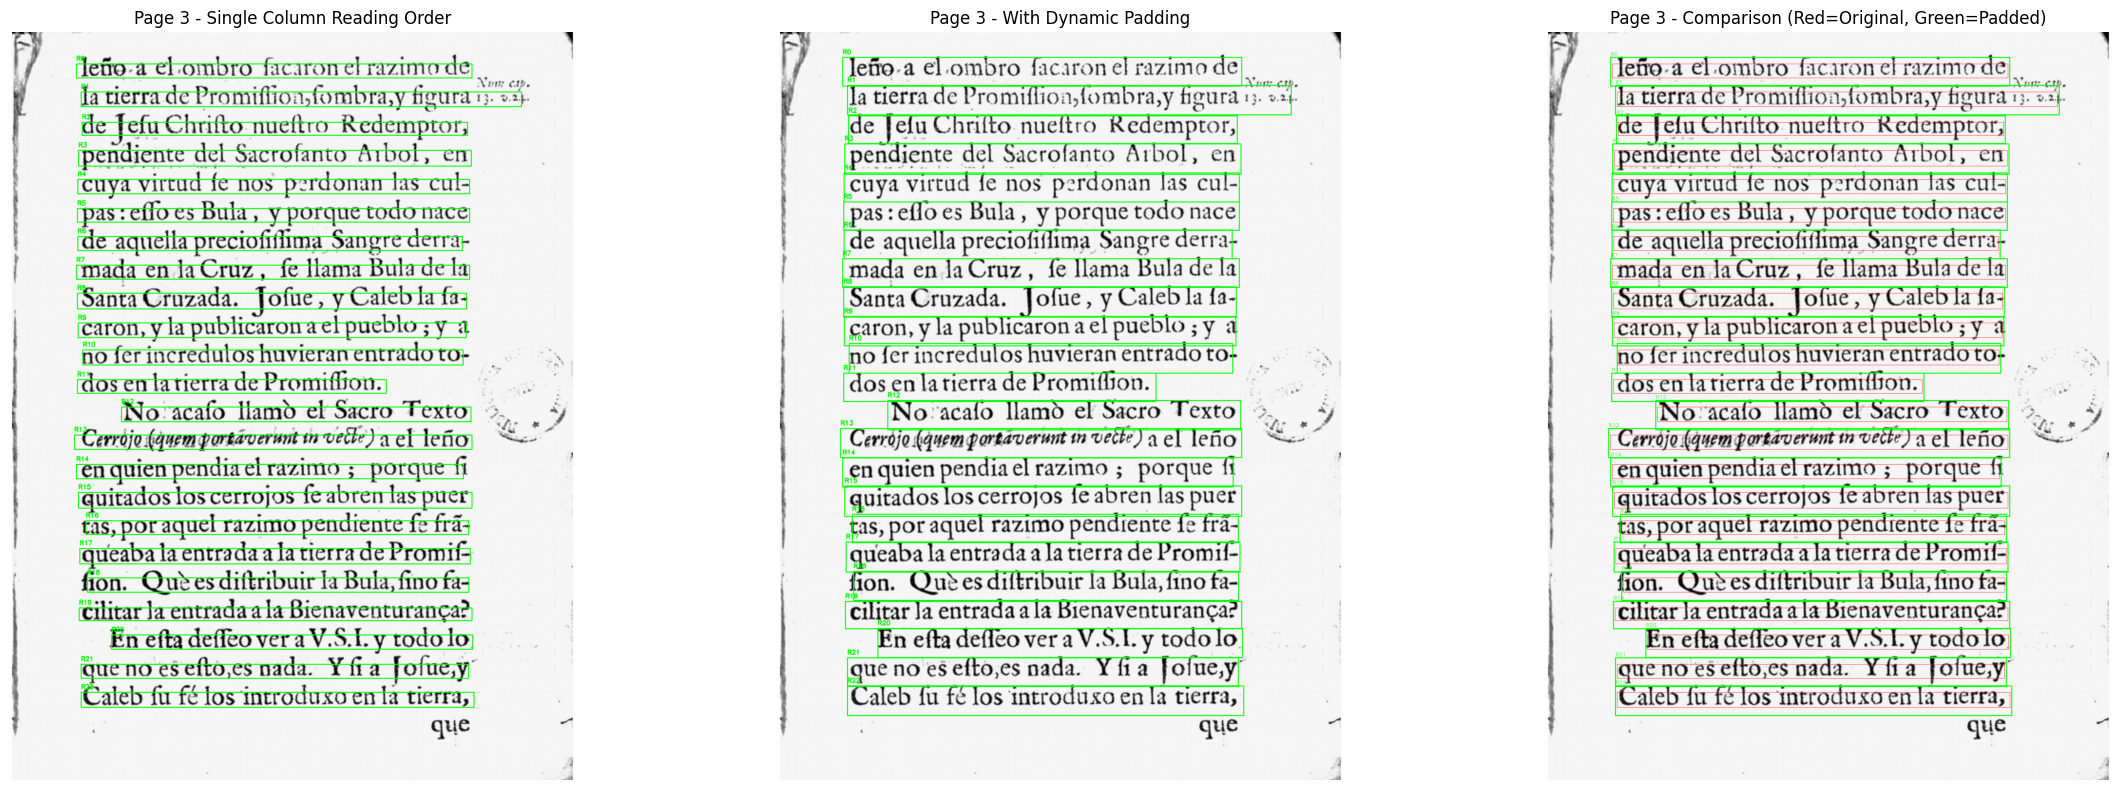

Applied padding: {'top': 19, 'bottom': 24, 'left': 5, 'right': 5}
Reading order: Single column with 23 textlines top-to-bottom


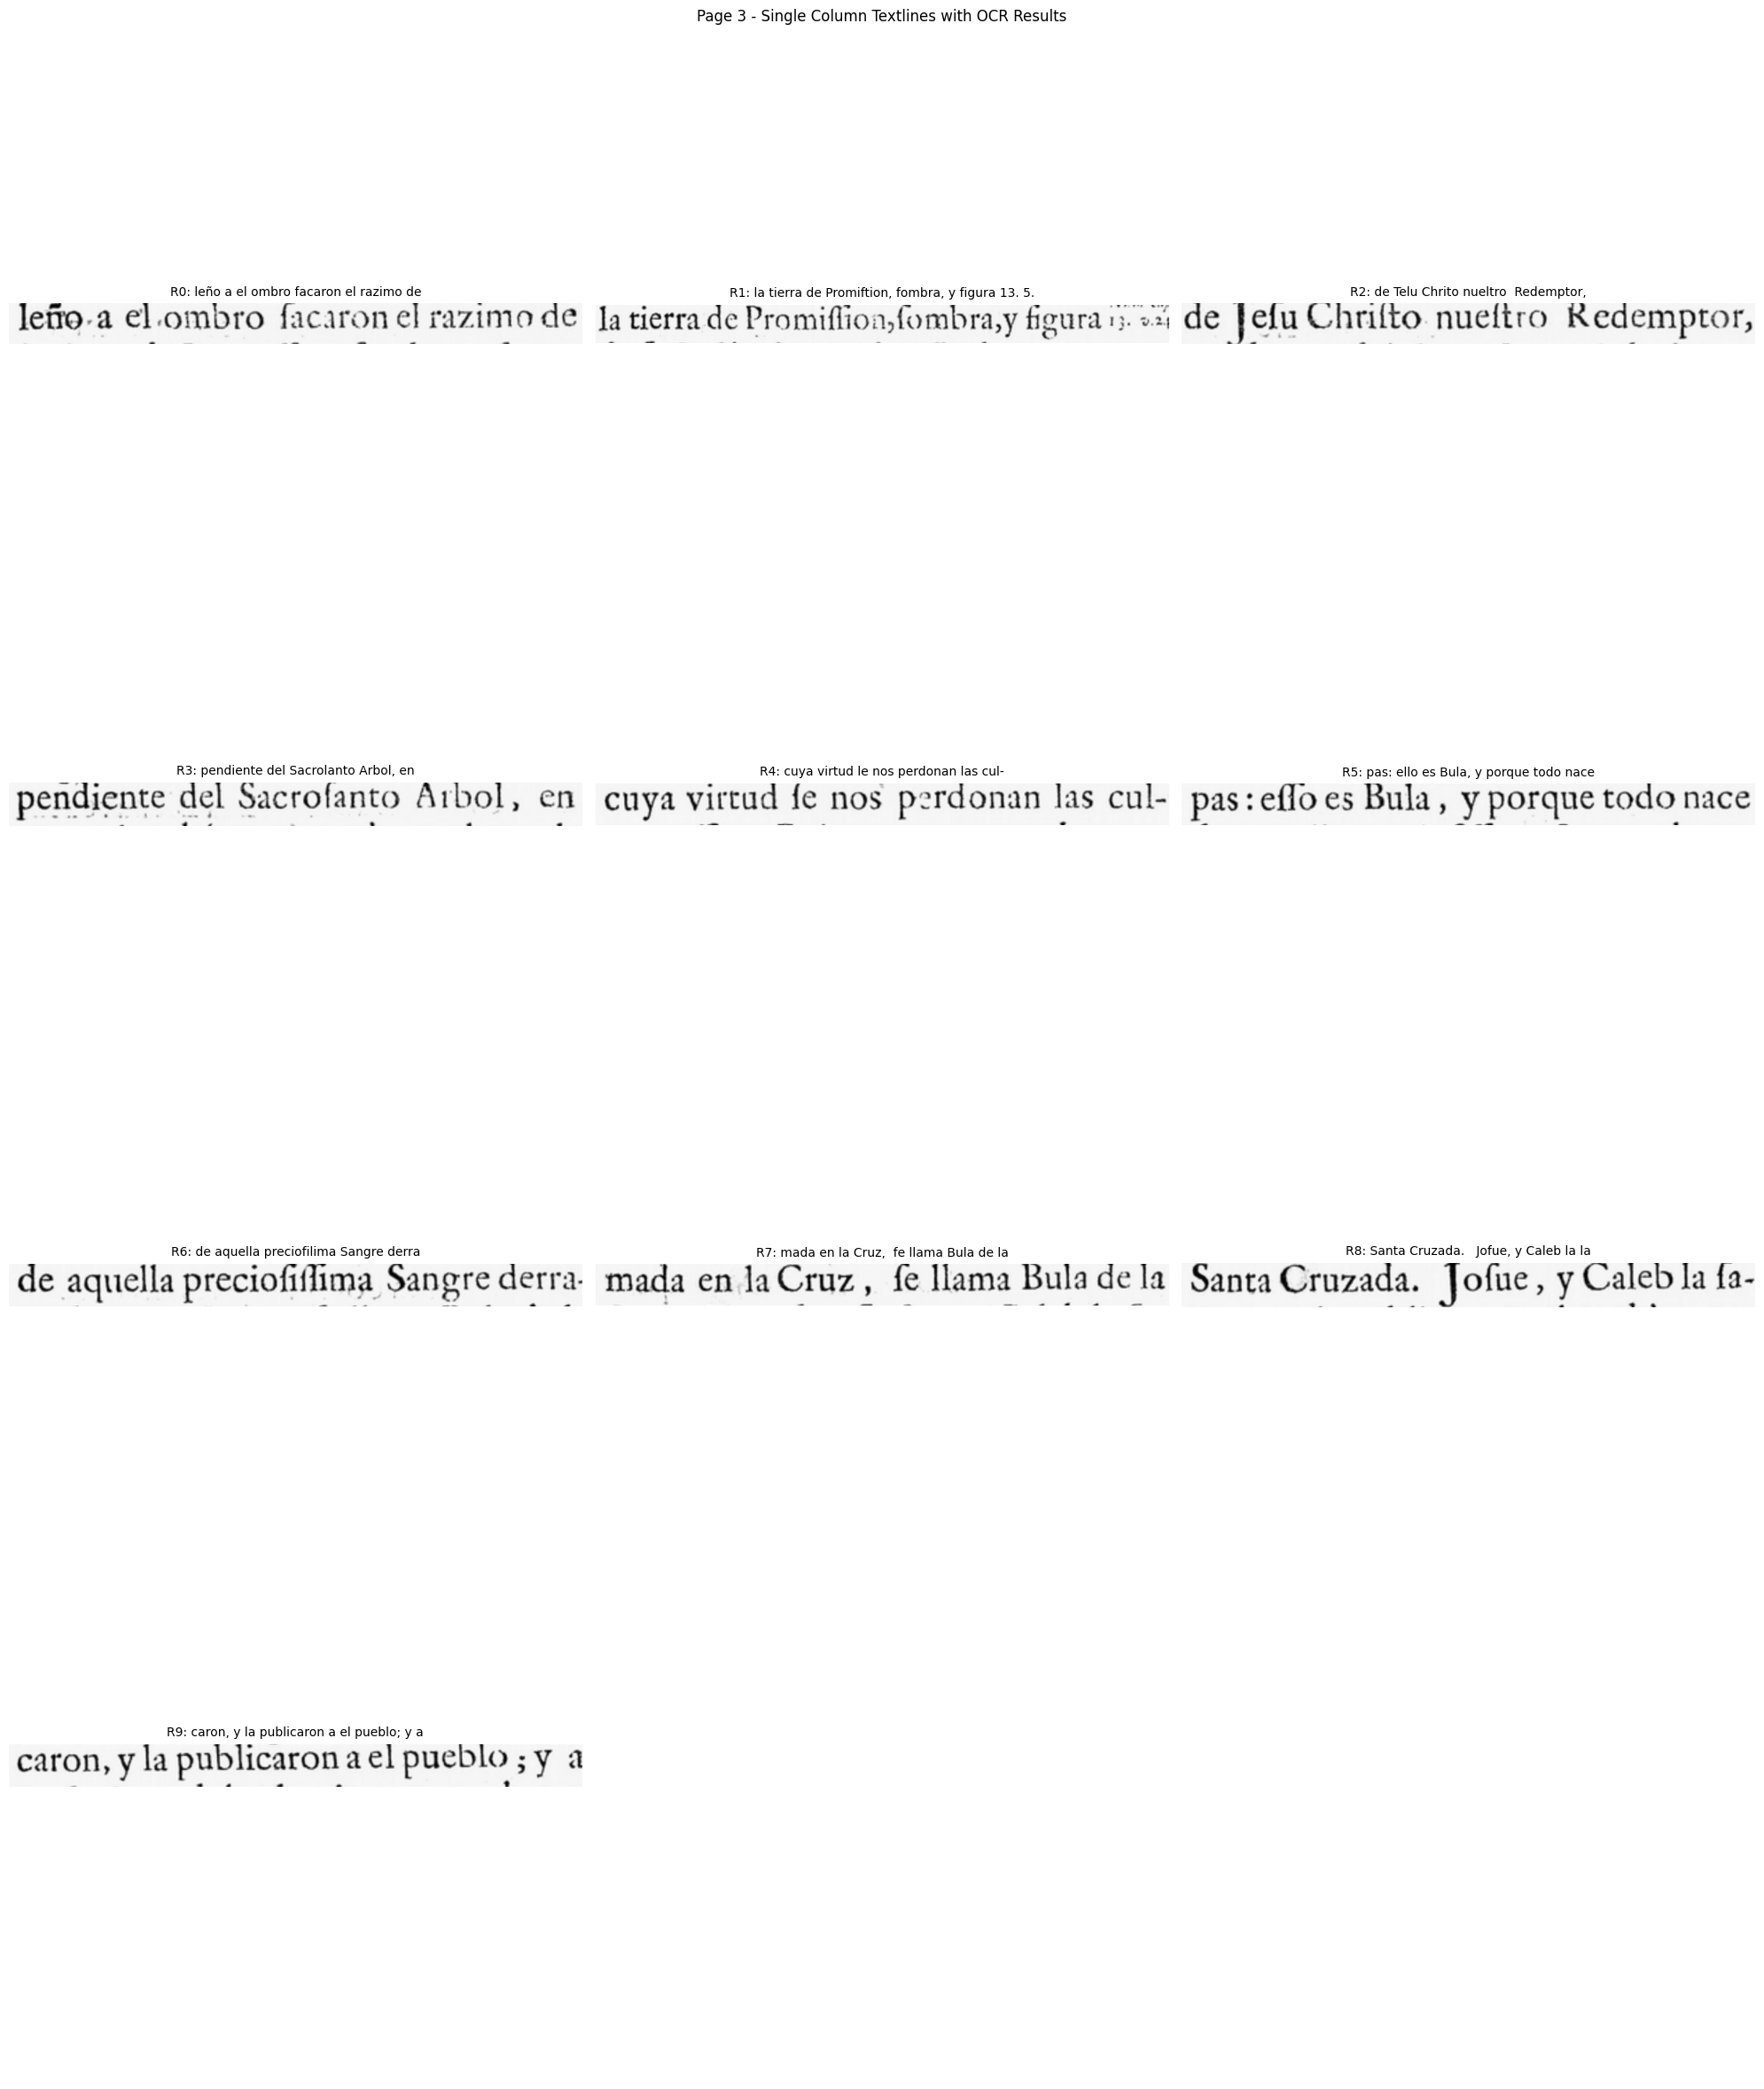


Processing Page 4/11...
Found 29 textlines
Area filtering: avg_area=35787.2, threshold=4473.4
Kept 25 boxes, filtered 4 small boxes
FORCING SINGLE COLUMN DETECTION
Processing 25 textlines as single column
Single column contains 25 textlines
Sorting textlines TOP-to-BOTTOM:
  Reading order 0: textline 15 at y=113.1
  Reading order 1: textline 3 at y=196.4
  Reading order 2: textline 9 at y=281.9
  Reading order 3: textline 2 at y=365.6
  Reading order 4: textline 22 at y=450.2
  Reading order 5: textline 8 at y=534.1
  Reading order 6: textline 11 at y=618.2
  Reading order 7: textline 14 at y=693.4
  Reading order 8: textline 21 at y=773.5
  Reading order 9: textline 18 at y=852.5
  Reading order 10: textline 7 at y=927.1
  Reading order 11: textline 0 at y=1013.8
  Reading order 12: textline 6 at y=1096.1
  Reading order 13: textline 1 at y=1180.7
  Reading order 14: textline 19 at y=1264.7
  Reading order 15: textline 10 at y=1348.9
  Reading order 16: textline 12 at y=1435.1
  Read

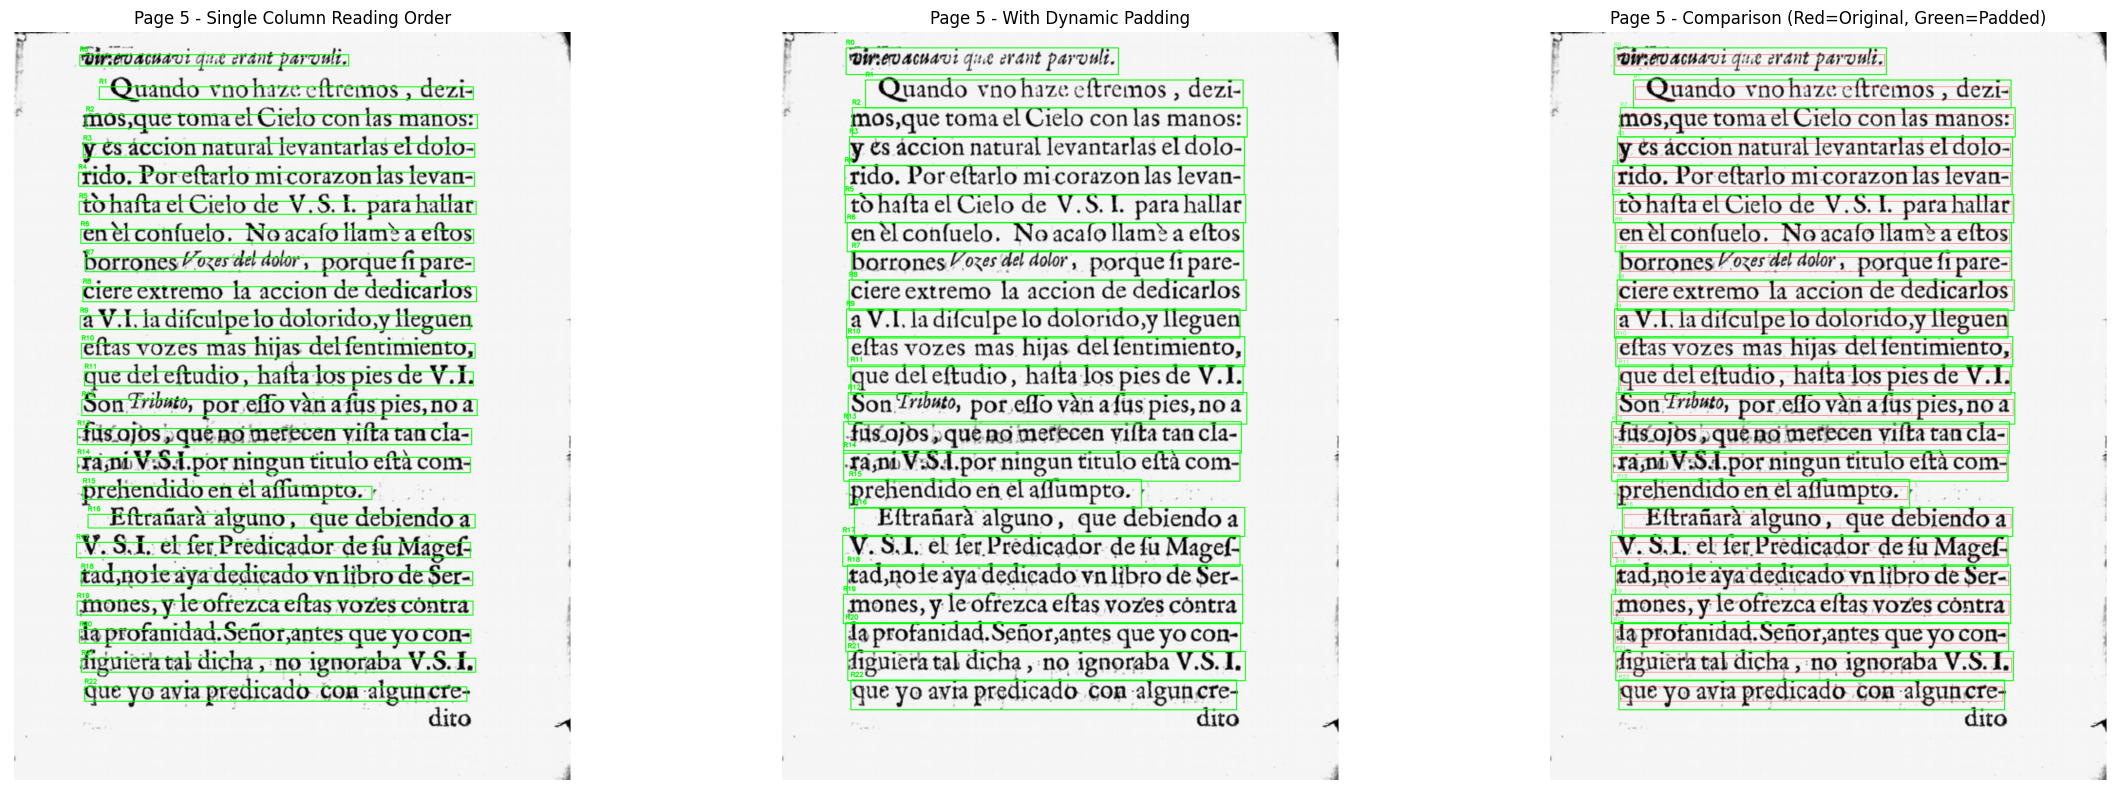

Applied padding: {'top': 20, 'bottom': 25, 'left': 5, 'right': 5}
Reading order: Single column with 23 textlines top-to-bottom


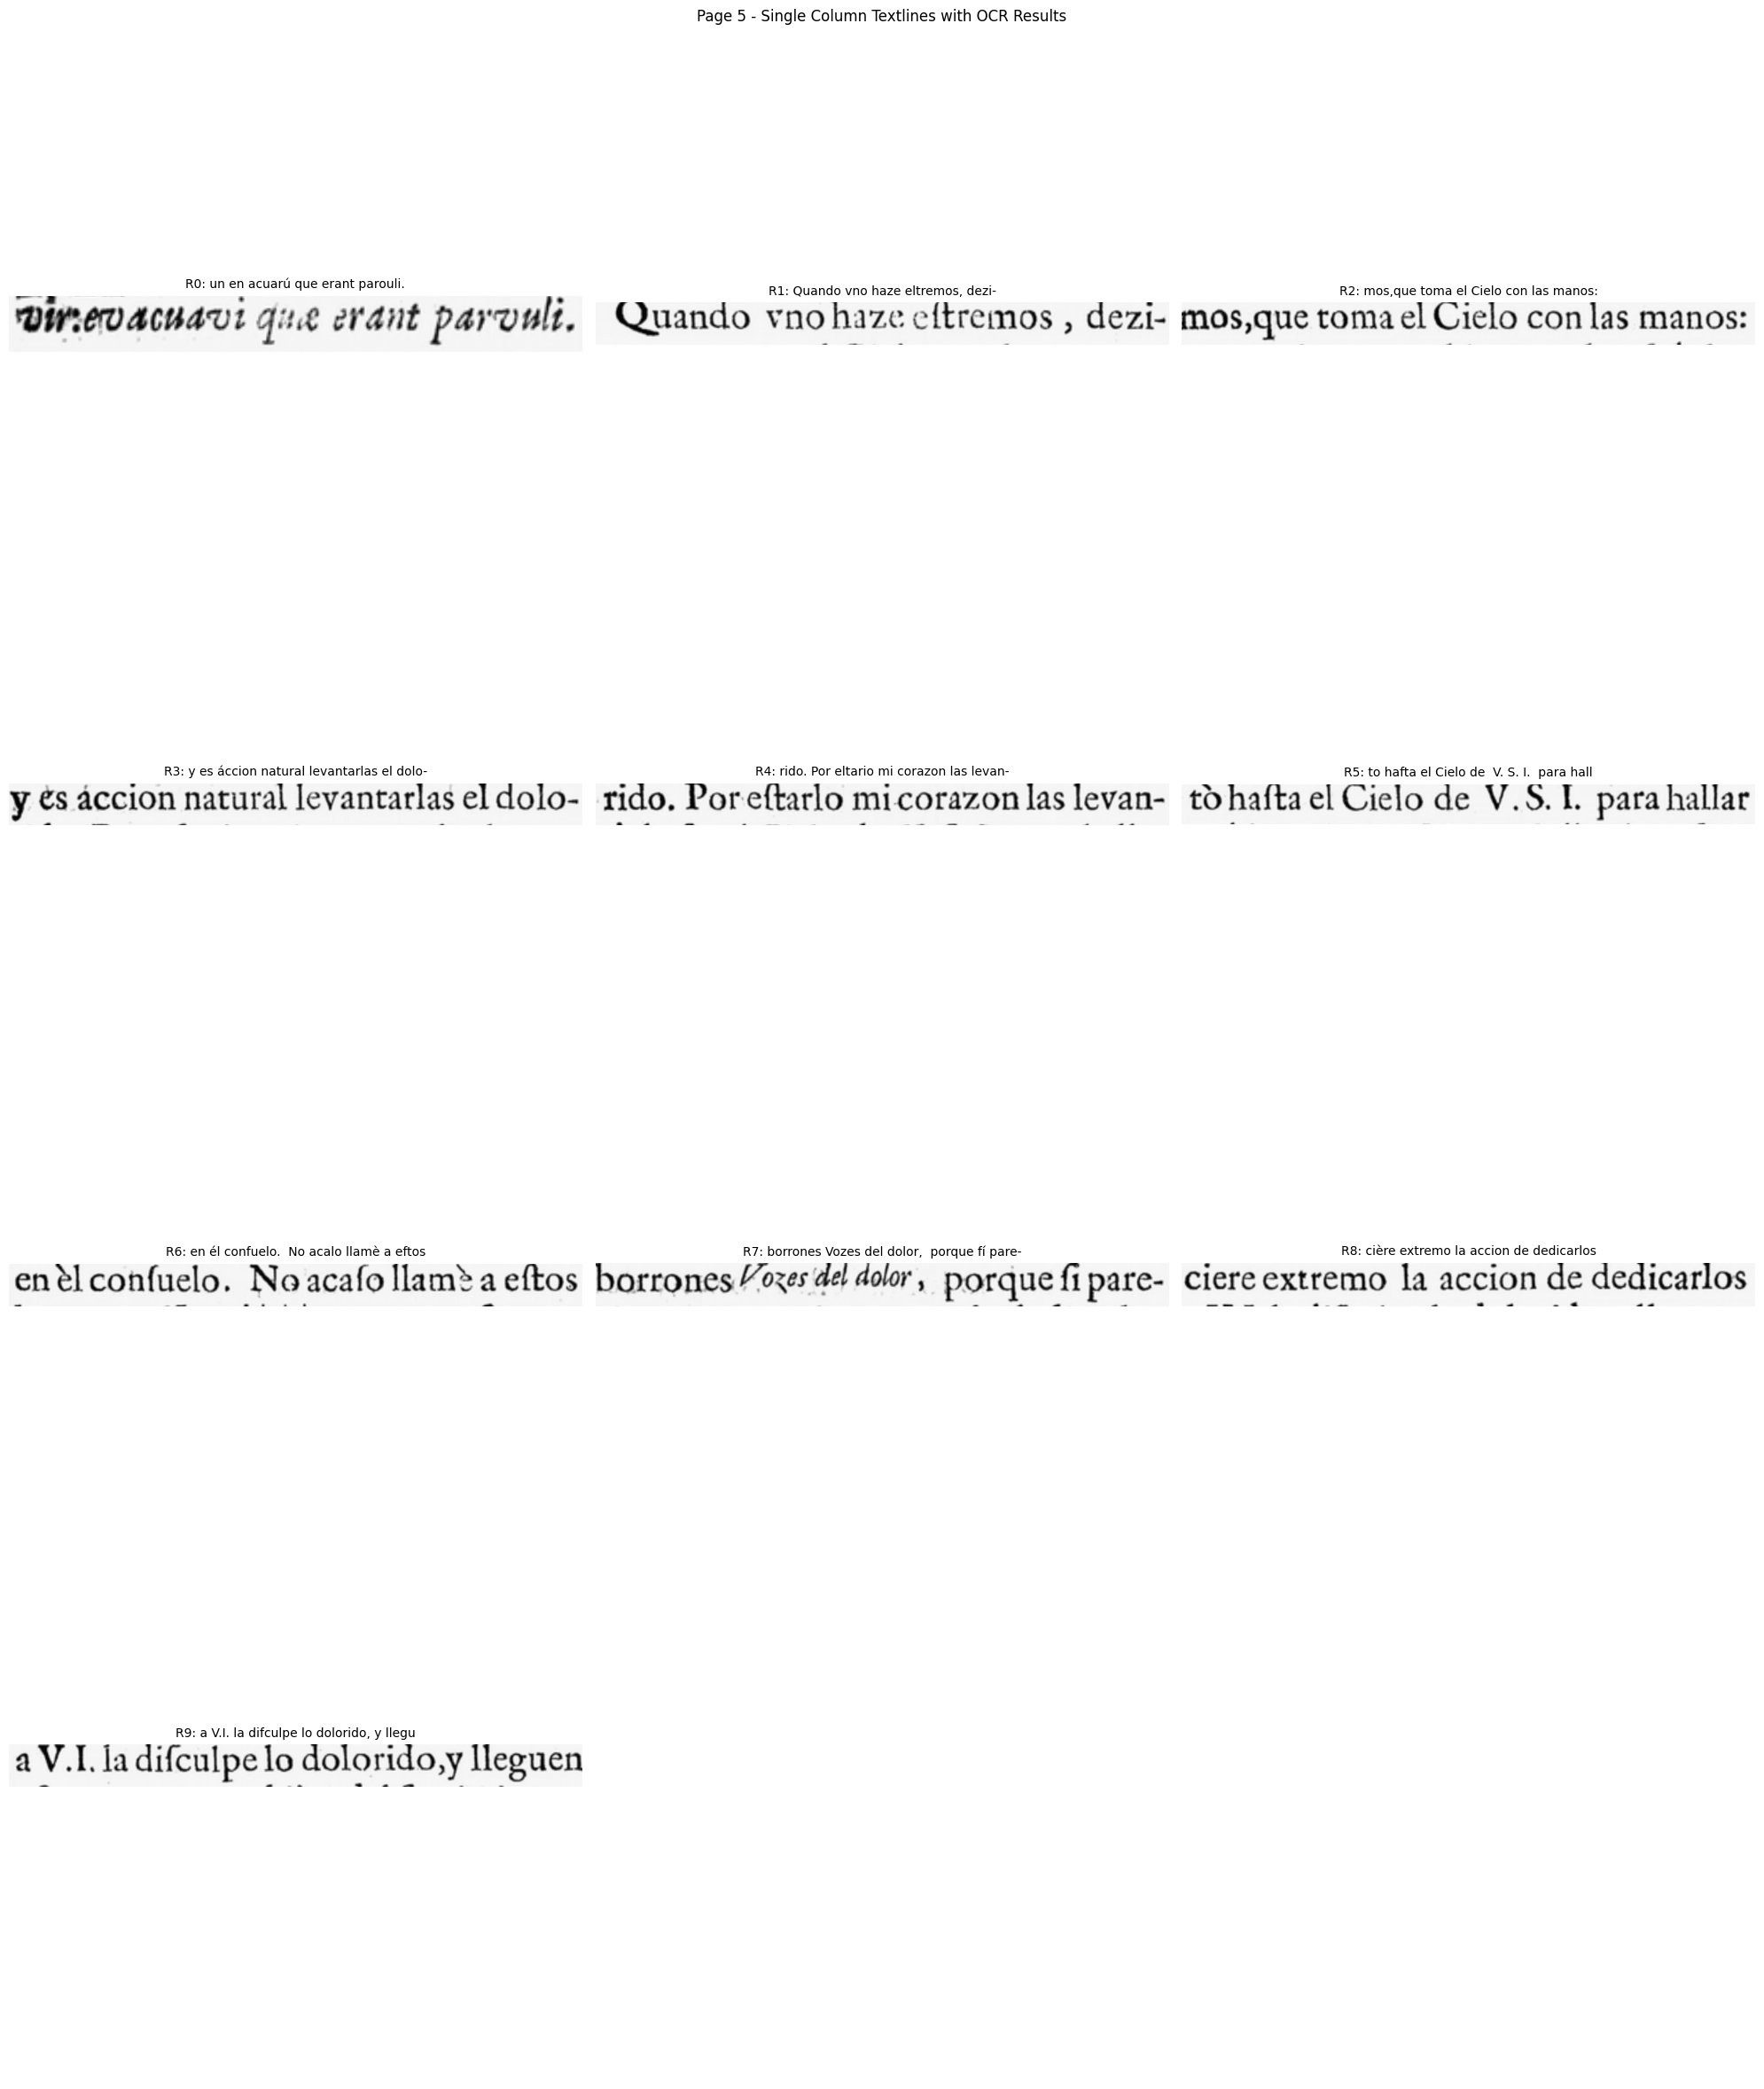


Processing Page 6/11...
Found 25 textlines
Area filtering: avg_area=42267.2, threshold=5283.4
Kept 23 boxes, filtered 2 small boxes
FORCING SINGLE COLUMN DETECTION
Processing 23 textlines as single column
Single column contains 23 textlines
Sorting textlines TOP-to-BOTTOM:
  Reading order 0: textline 18 at y=100.5
  Reading order 1: textline 16 at y=188.0
  Reading order 2: textline 8 at y=271.3
  Reading order 3: textline 11 at y=354.3
  Reading order 4: textline 10 at y=439.0
  Reading order 5: textline 13 at y=521.1
  Reading order 6: textline 3 at y=605.9
  Reading order 7: textline 12 at y=688.0
  Reading order 8: textline 22 at y=772.8
  Reading order 9: textline 9 at y=856.4
  Reading order 10: textline 21 at y=942.0
  Reading order 11: textline 14 at y=1026.3
  Reading order 12: textline 17 at y=1109.0
  Reading order 13: textline 1 at y=1190.9
  Reading order 14: textline 2 at y=1275.4
  Reading order 15: textline 5 at y=1359.8
  Reading order 16: textline 6 at y=1443.5
  Rea

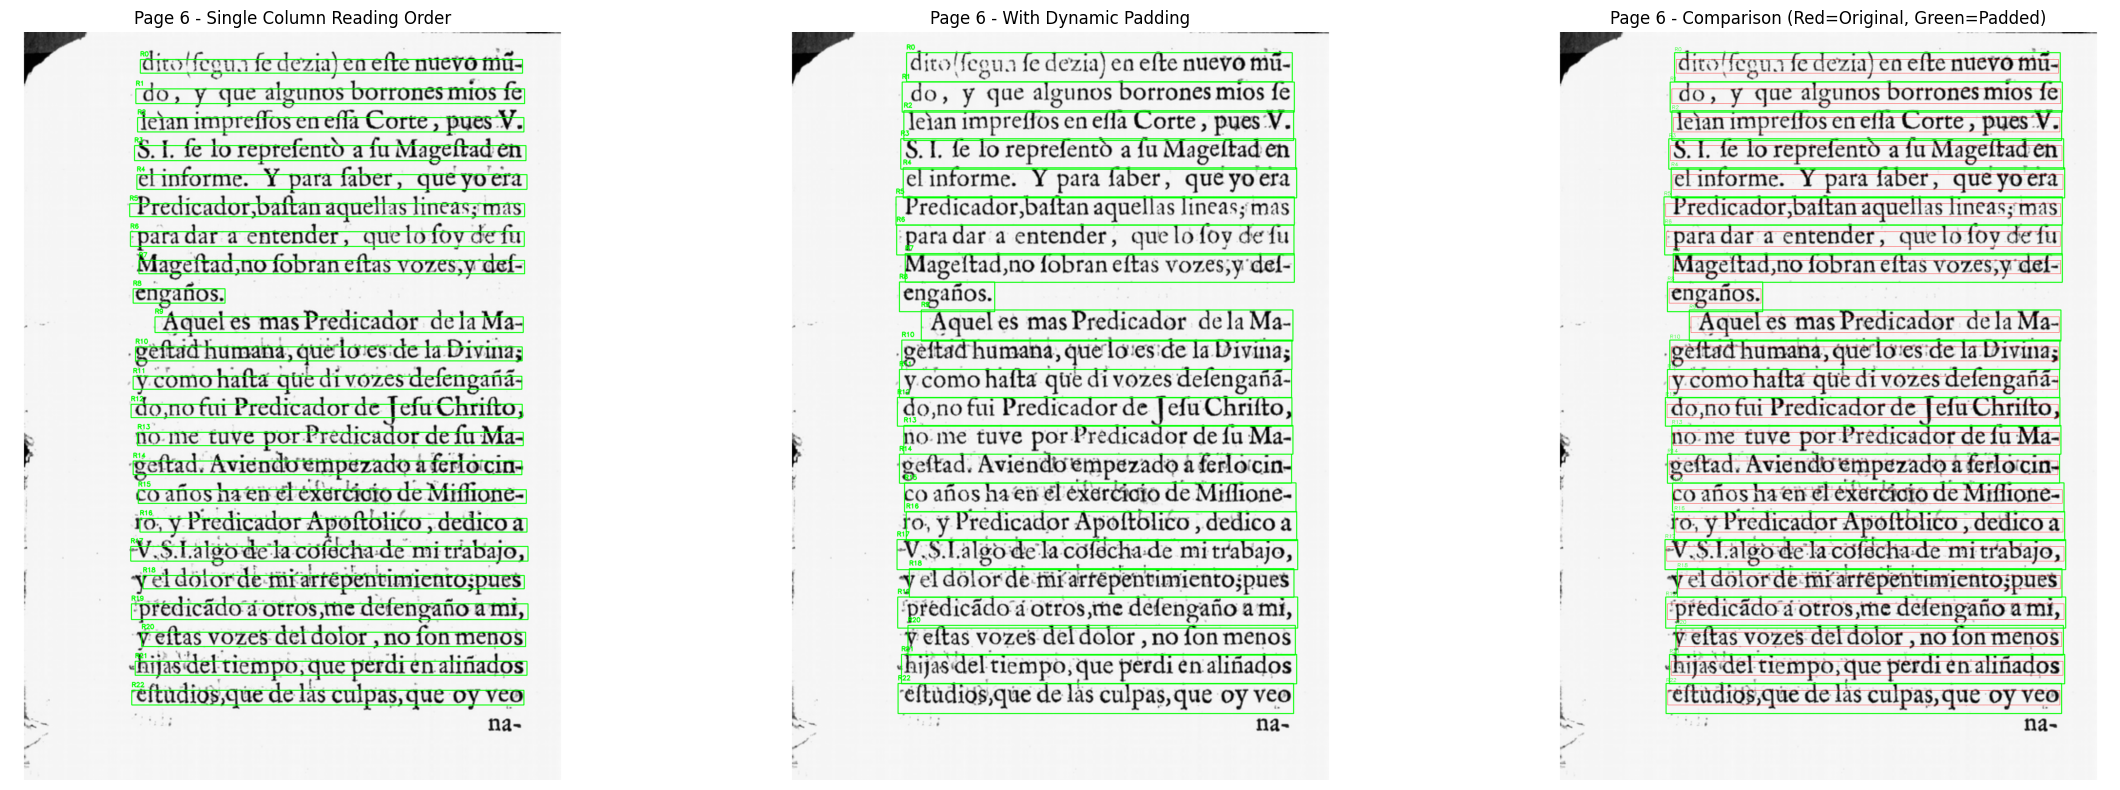

Applied padding: {'top': 20, 'bottom': 25, 'left': 5, 'right': 5}
Reading order: Single column with 23 textlines top-to-bottom


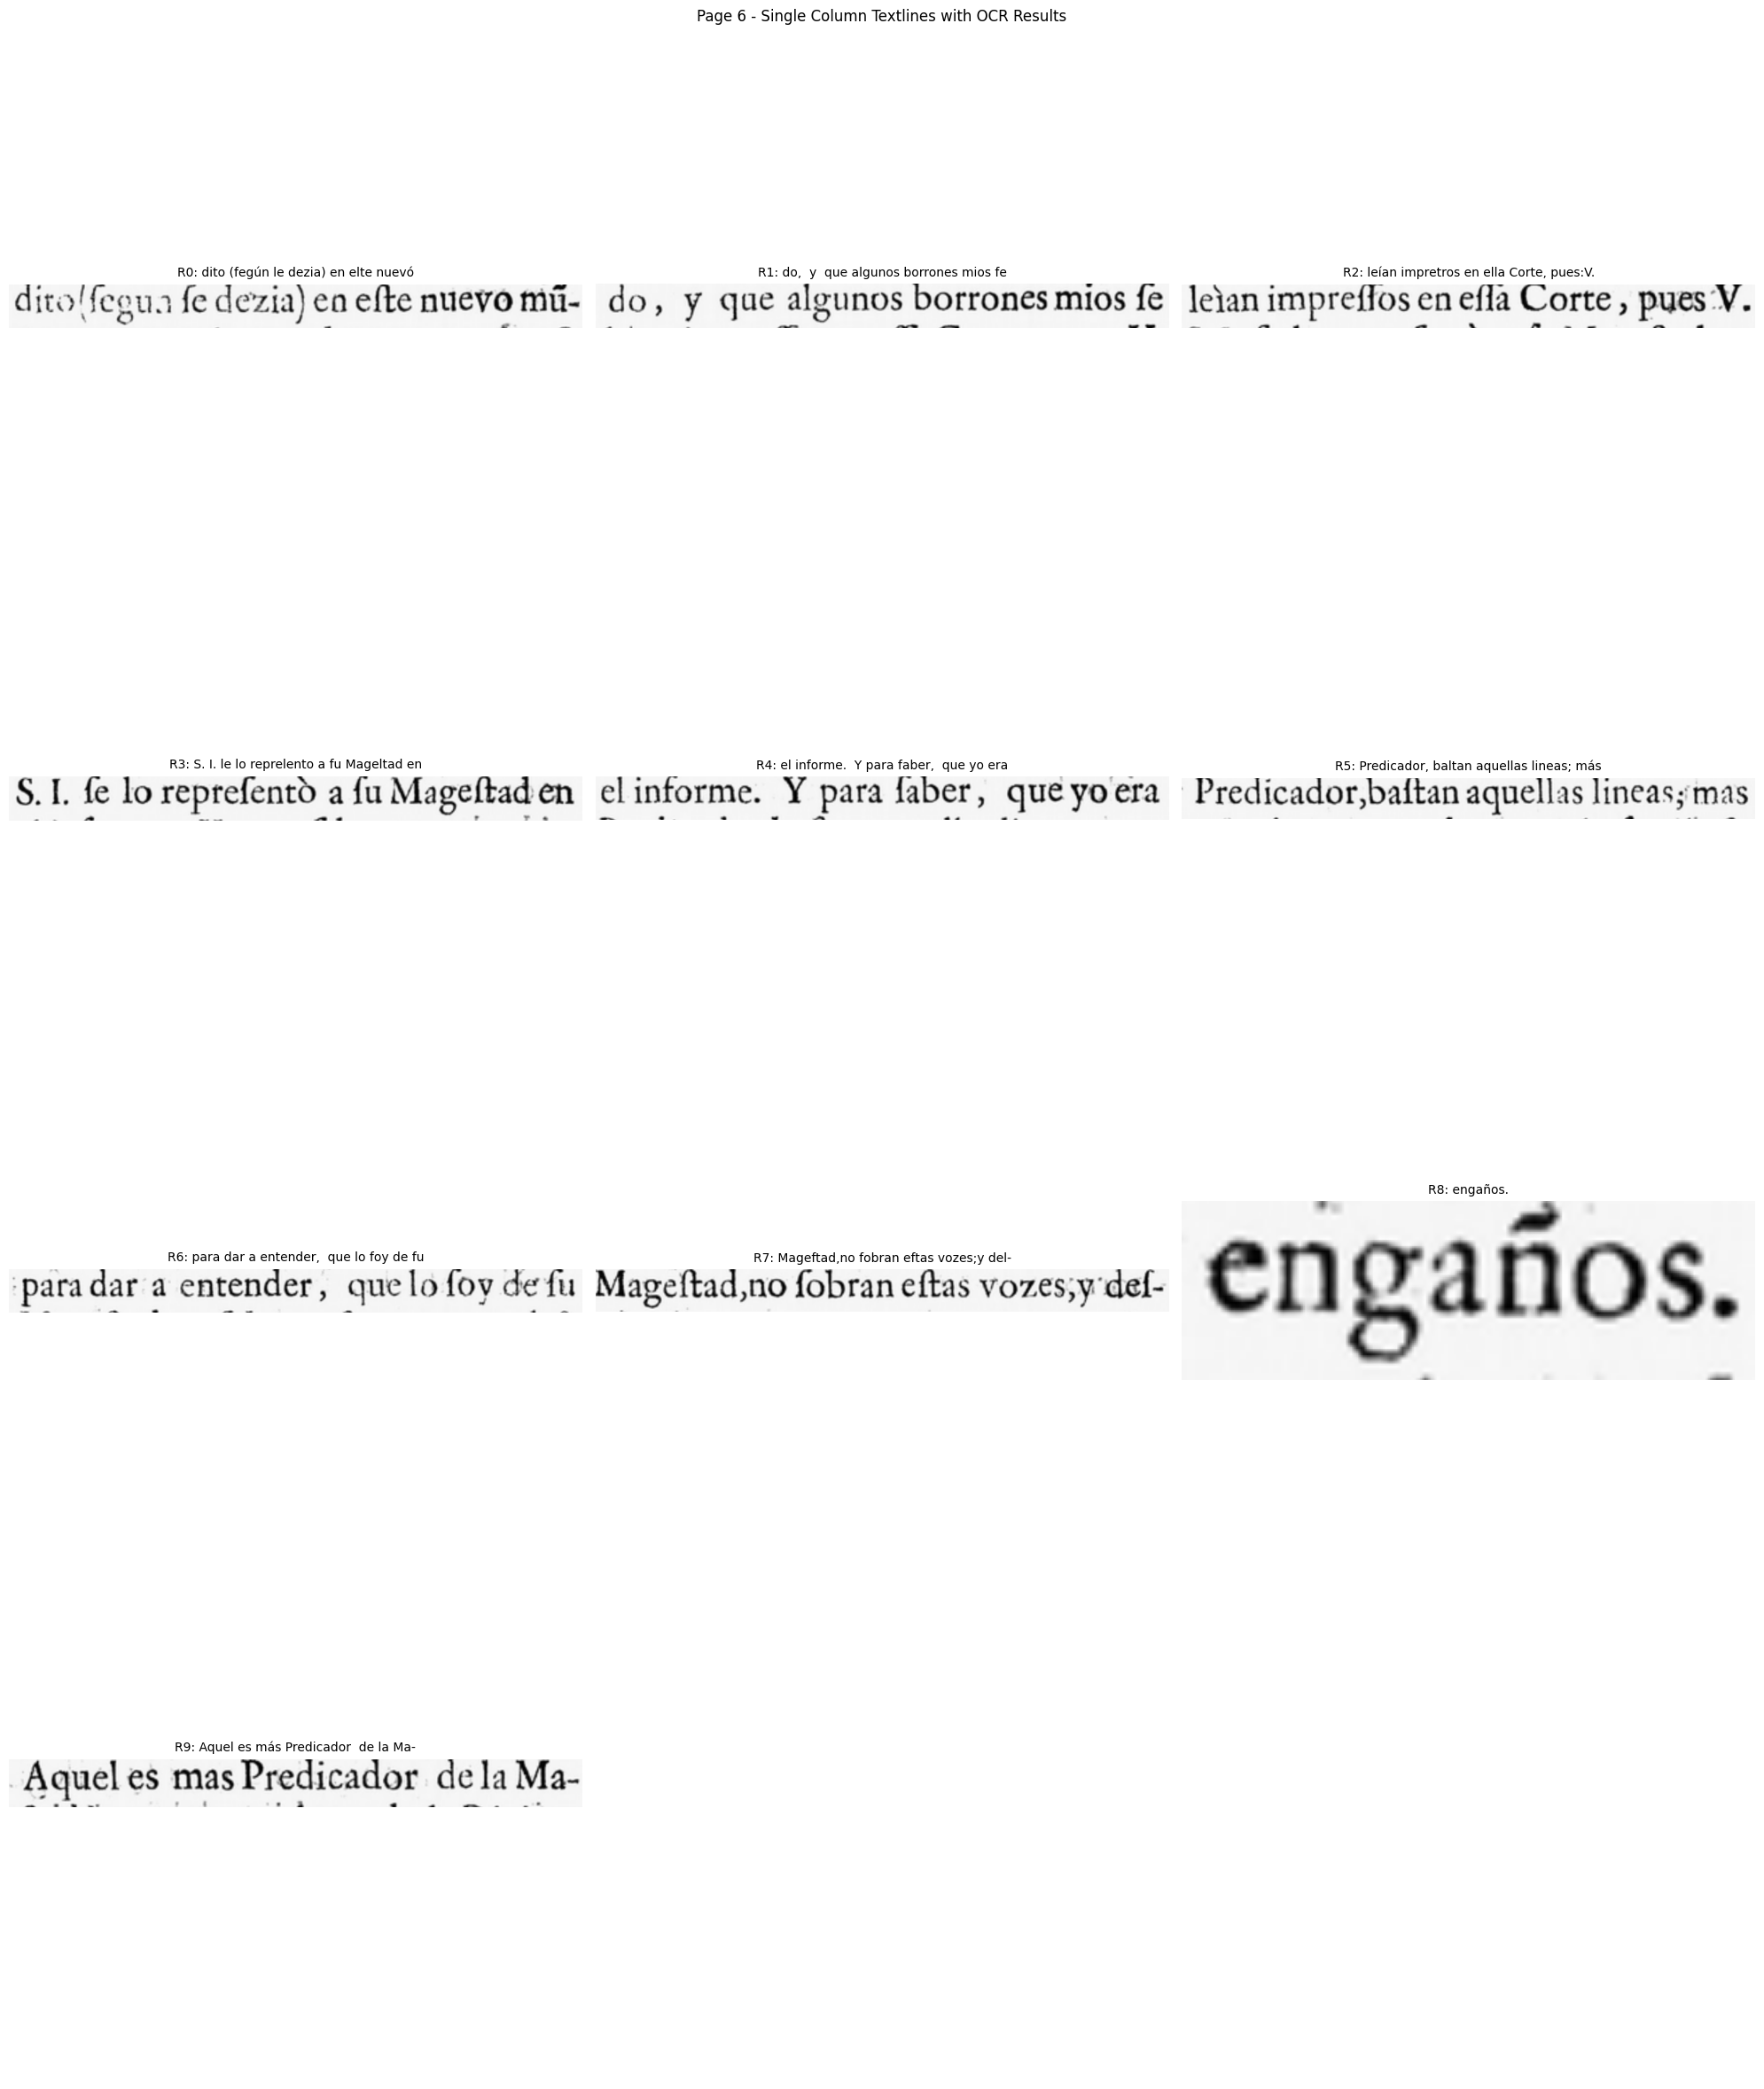


Processing Page 7/11...
Found 26 textlines
Area filtering: avg_area=42329.8, threshold=5291.2
Kept 23 boxes, filtered 3 small boxes
FORCING SINGLE COLUMN DETECTION
Processing 23 textlines as single column
Single column contains 23 textlines
Sorting textlines TOP-to-BOTTOM:
  Reading order 0: textline 21 at y=104.7
  Reading order 1: textline 18 at y=187.2
  Reading order 2: textline 12 at y=272.9
  Reading order 3: textline 0 at y=358.8
  Reading order 4: textline 20 at y=445.6
  Reading order 5: textline 3 at y=529.4
  Reading order 6: textline 17 at y=614.0
  Reading order 7: textline 11 at y=700.7
  Reading order 8: textline 15 at y=785.5
  Reading order 9: textline 7 at y=870.4
  Reading order 10: textline 2 at y=948.9
  Reading order 11: textline 10 at y=1037.5
  Reading order 12: textline 14 at y=1121.0
  Reading order 13: textline 19 at y=1206.4
  Reading order 14: textline 1 at y=1284.2
  Reading order 15: textline 5 at y=1369.7
  Reading order 16: textline 6 at y=1454.1
  Rea

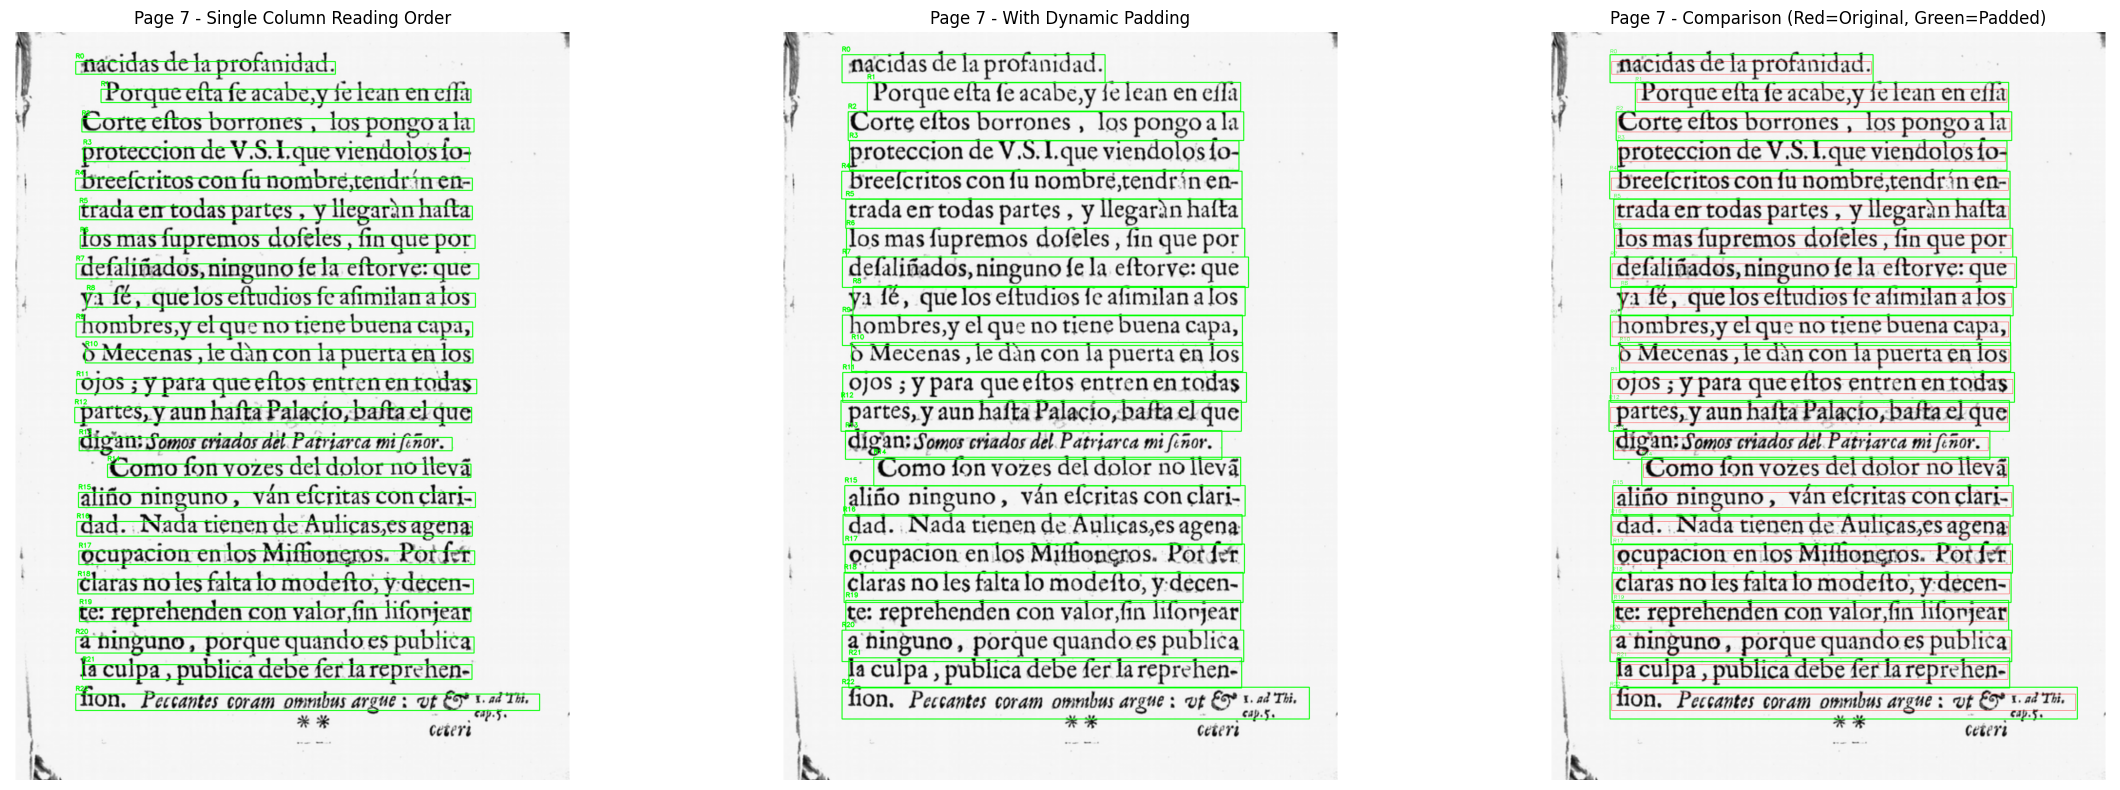

Applied padding: {'top': 20, 'bottom': 25, 'left': 5, 'right': 5}
Reading order: Single column with 23 textlines top-to-bottom


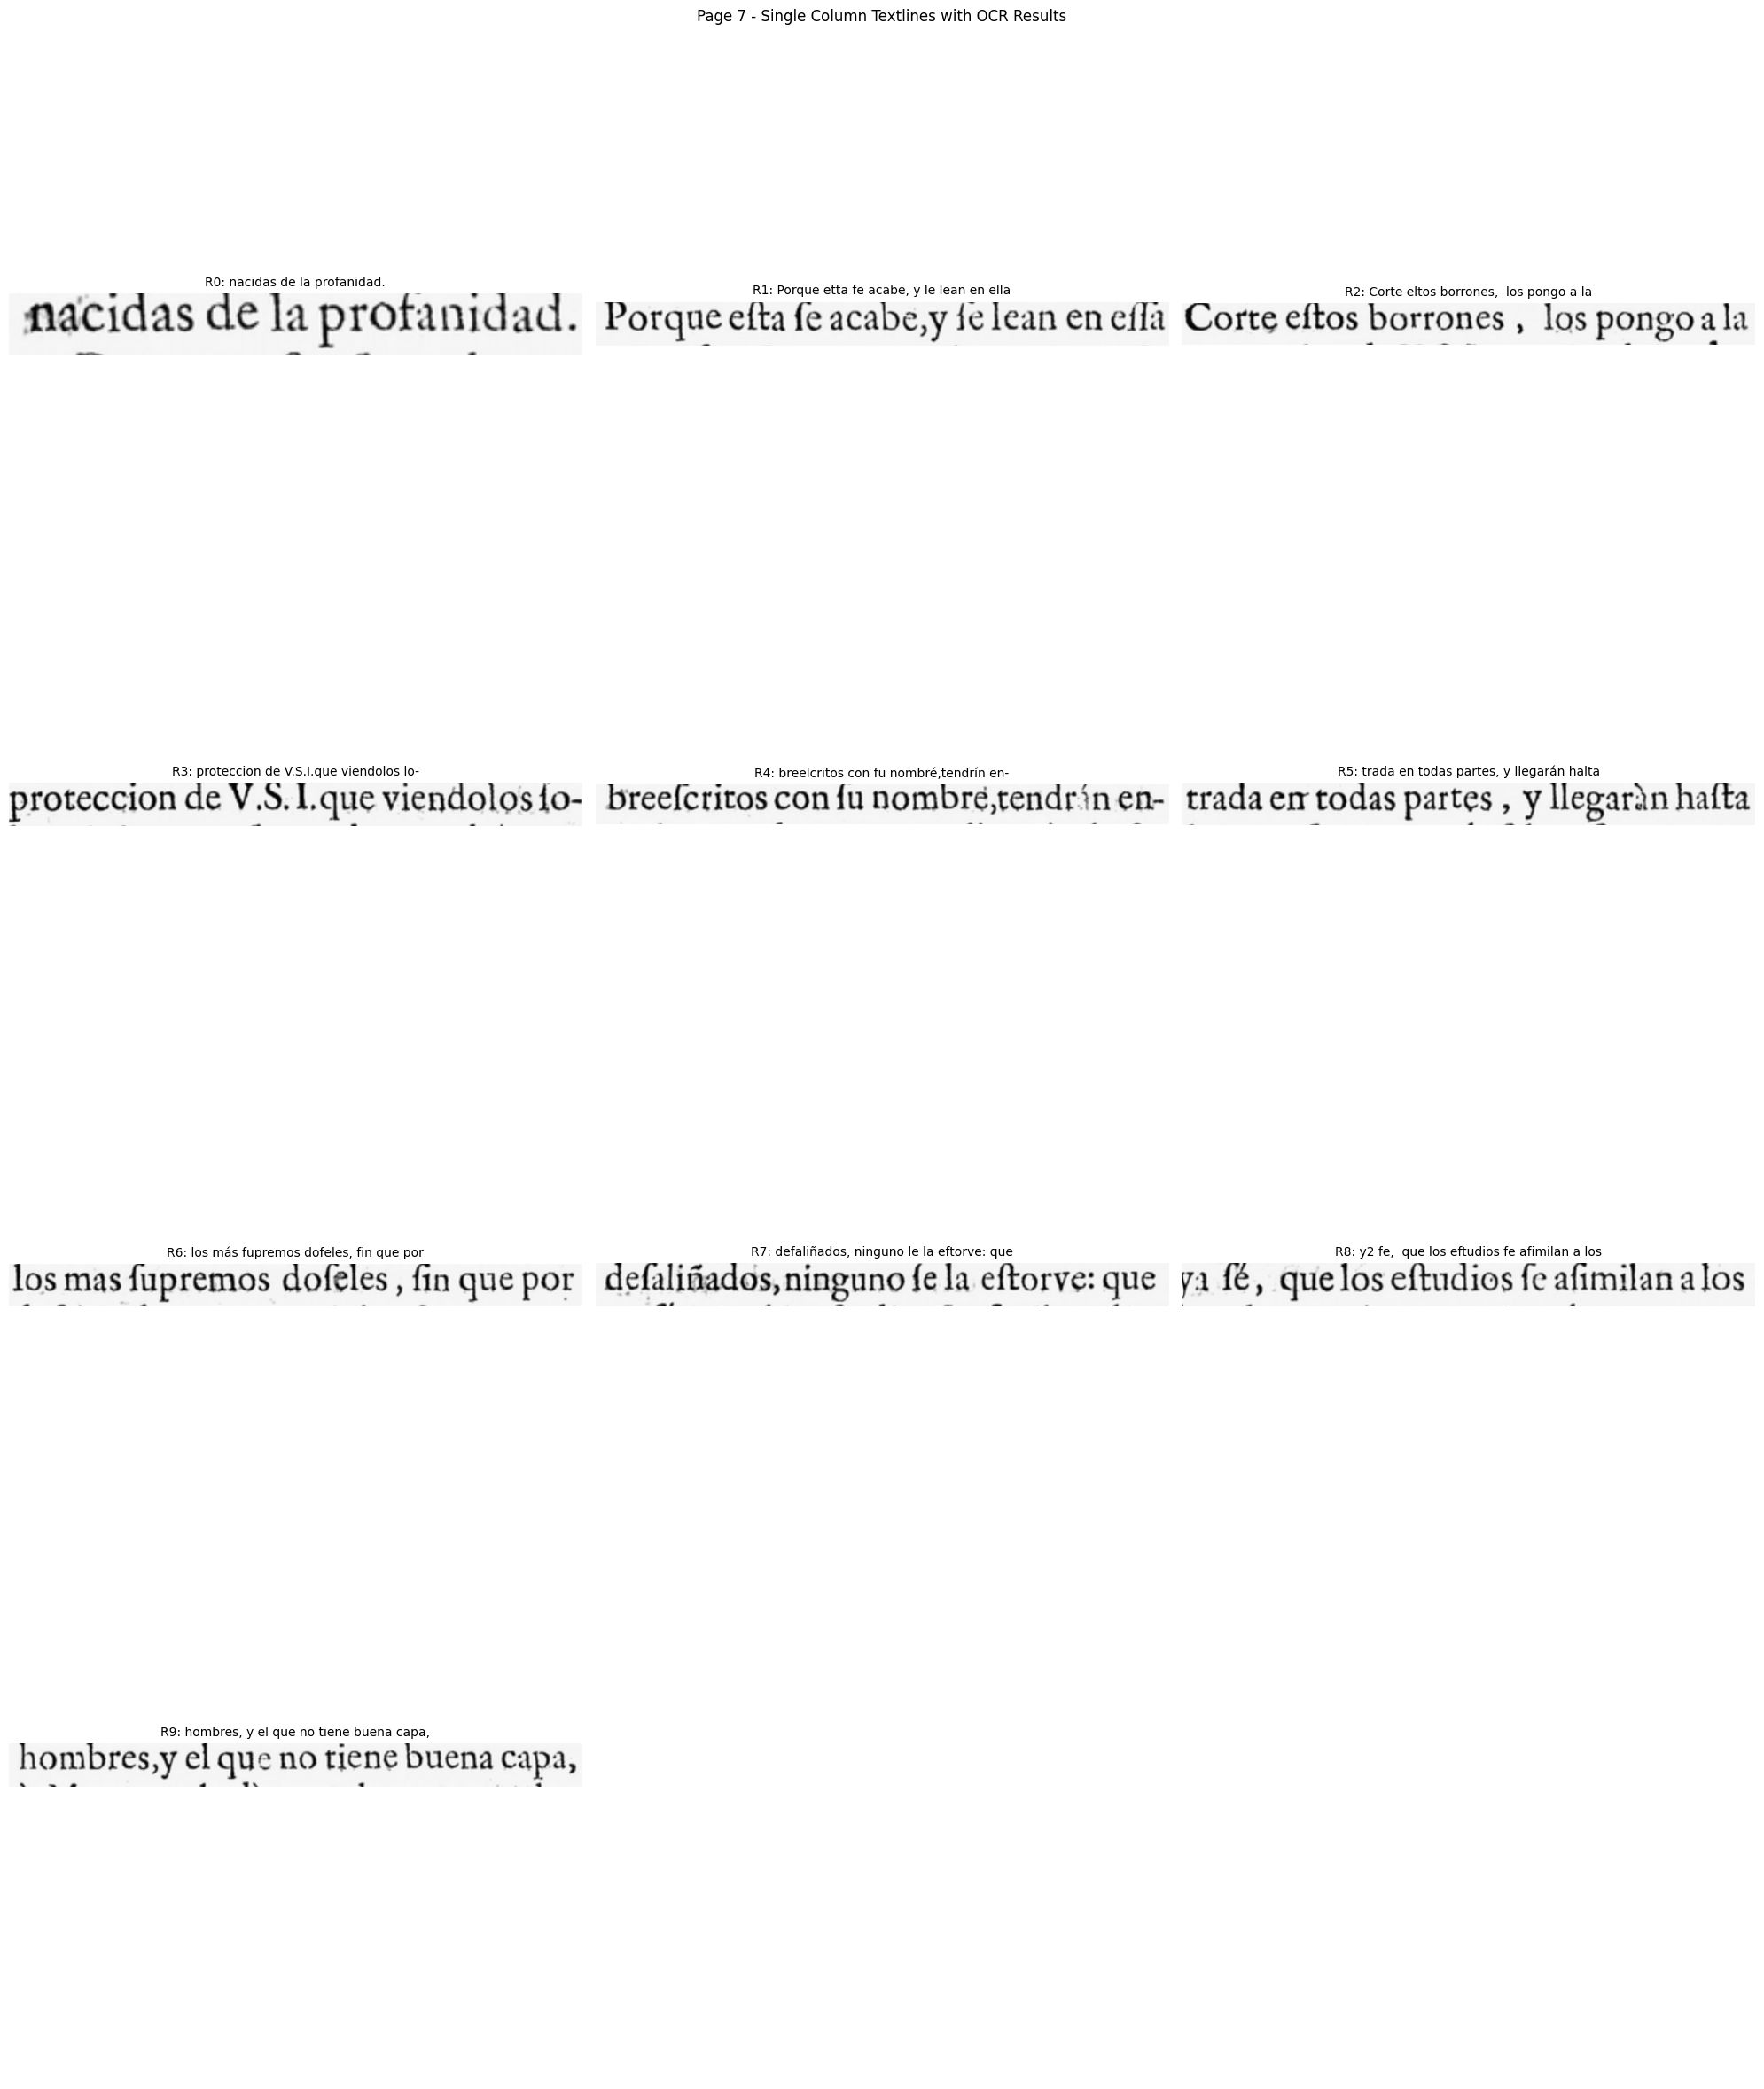


Processing Page 8/11...
Found 24 textlines
Area filtering: avg_area=43705.4, threshold=5463.2
Kept 23 boxes, filtered 1 small boxes
FORCING SINGLE COLUMN DETECTION
Processing 23 textlines as single column
Single column contains 23 textlines
Sorting textlines TOP-to-BOTTOM:
  Reading order 0: textline 22 at y=111.7
  Reading order 1: textline 10 at y=204.4
  Reading order 2: textline 1 at y=286.2
  Reading order 3: textline 12 at y=374.4
  Reading order 4: textline 8 at y=455.0
  Reading order 5: textline 15 at y=542.1
  Reading order 6: textline 20 at y=625.3
  Reading order 7: textline 5 at y=712.4
  Reading order 8: textline 4 at y=793.6
  Reading order 9: textline 18 at y=877.8
  Reading order 10: textline 17 at y=963.5
  Reading order 11: textline 9 at y=1047.1
  Reading order 12: textline 3 at y=1131.6
  Reading order 13: textline 2 at y=1215.3
  Reading order 14: textline 19 at y=1300.6
  Reading order 15: textline 11 at y=1386.0
  Reading order 16: textline 13 at y=1470.7
  Rea

In [8]:
process_pdf_with_trocr("/kaggle/input/ezcarazvozes/Ezcaray - Vozes (1).pdf", "/kaggle/input/maskrcnnr101fpn_final/pytorch/default/1/model_final (8).pth", "output_with_ocr", max_pages=50, display_pages=5)

In [9]:
pip install google-generativeai python-dotenv

Note: you may need to restart the kernel to use updated packages.


In [ ]:
GEMINI_API_KEY='GEMINI_API_KEY'

In [11]:
import os
import json
import time
from pathlib import Path
from dotenv import load_dotenv
import google.generativeai as genai
from typing import List, Dict, Tuple, Optional

In [ ]:
# --- Configuration --- #
# def load_environment():
#     """Load environment variables from .env file"""
#     # load_dotenv('./gemini.env')  # Create this file with GEMINI_API_KEY=your_key
#     # return os.getenv("GEMINI_API_KEY")
#     return os.environ.get("GEMINI_API_KEY")  # Set this in Kaggle secrets
def load_environment():
    return "GEMINI_API_KEY"

def select_pages_folder() -> str:
    """Interactive folder selection"""
    print("Available folders in current directory:")
    current_dir = Path.cwd()
    folders = [f for f in current_dir.iterdir() if f.is_dir()]
    
    if not folders:
        print("No folders found in current directory!")
        return None
    
    for i, folder in enumerate(folders, 1):
        print(f"{i}. {folder.name}")
    
    while True:
        try:
            choice = input("\nSelect folder number (or enter folder path directly): ").strip()
            
            # Check if it's a direct path
            if os.path.exists(choice) and os.path.isdir(choice):
                return choice
            
            # Check if it's a number selection
            choice_num = int(choice)
            if 1 <= choice_num <= len(folders):
                return str(folders[choice_num - 1])
            else:
                print("Invalid selection. Please try again.")
        except ValueError:
            print("Please enter a valid number or folder path.")

def get_page_folders(base_path: str) -> List[Path]:
    """Get all page folders sorted by page number"""
    base_path = Path(base_path)
    page_folders = []
    
    for folder in base_path.iterdir():
        if folder.is_dir() and folder.name.startswith('page_'):
            page_folders.append(folder)
    
    # Sort by page number
    page_folders.sort(key=lambda x: int(x.name.split('_')[1]))
    return page_folders

In [13]:
def read_text_file(file_path: Path) -> str:
    """Read text file with multiple encoding attempts"""
    encodings = ['utf-8', 'latin-1', 'iso-8859-1', 'cp1252']
    
    for encoding in encodings:
        try:
            with open(file_path, 'r', encoding=encoding) as f:
                return f.read().strip()
        except UnicodeDecodeError:
            continue
    
    print(f"Warning: Could not read {file_path} with any encoding")
    return ""

In [14]:
def get_last_two_lines(text: str) -> str:
    """Extract last two lines from text for context"""
    if not text:
        return ""
    
    lines = text.strip().split('\n')
    if len(lines) >= 2:
        return '\n'.join(lines[-2:])
    elif len(lines) == 1:
        return lines[0]
    return ""

In [15]:
# --- Text Processing --- #
def create_correction_prompt(text: str, context: str = "") -> str:
    """Create structured prompt for text correction with context"""
    context_section = ""
    if context:
        context_section = f"""
    Previous page context (last 2 lines):
    {context}
    
    """
    
    return f"""
    Correct the following historical Spanish OCR text while PRESERVING ORIGINAL GRAMMAR AND STYLE.
    Only fix orthographic errors, punctuation, and obvious OCR mistakes. Maintain original capitalization and formatting.
    {context_section}
    Current page text to correct:
    {text}

    Instructions:
    - Fix spelling errors and OCR artifacts
    - Preserve historical language patterns
    - Maintain original line breaks and formatting
    - Use context from previous page if helpful
    - Return ONLY the corrected text without additional comments

    Corrected text:
    """

In [16]:
def process_text(text: str, context: str = "", max_retries: int = 3) -> Tuple[str, str]:
    """Process text through Gemini API with error handling"""
    prompt = create_correction_prompt(text, context)

    for attempt in range(max_retries):
        try:
            response = genai.GenerativeModel('gemini-2.5-pro').generate_content(prompt)
            if response.candidates and response.text:
                return response.text.strip(), "success"
        except Exception as e:
            print(f"Attempt {attempt+1} failed: {str(e)}")
            time.sleep(2 ** attempt)  # Exponential backoff

    return "", "max_retries_exceeded"

In [17]:
def process_single_page(page_folder: Path, previous_context: str = "") -> Dict:
    """Process a single page folder"""
    text_file = page_folder / "text_sequential.txt"
    
    if not text_file.exists():
        print(f"Warning: {text_file} not found")
        return {
            "page": page_folder.name,
            "status": "file_not_found",
            "original_text": "",
            "corrected_text": "",
            "processing_time": 0
        }
    
    # Read original text
    original_text = read_text_file(text_file)
    
    if not original_text:
        return {
            "page": page_folder.name,
            "status": "empty_text",
            "original_text": "",
            "corrected_text": "",
            "processing_time": 0
        }
    
    # Process text
    start_time = time.time()
    corrected_text, status = process_text(original_text, previous_context)
    processing_time = time.time() - start_time
    
    return {
        "page": page_folder.name,
        "status": status,
        "original_text": original_text,
        "corrected_text": corrected_text,
        "processing_time": round(processing_time, 2)
    }

In [18]:
def save_corrected_text(page_folder: Path, corrected_text: str):
    """Save corrected text to the page folder"""
    output_file = page_folder / "text_sequential_corrected.txt"
    
    try:
        with open(output_file, 'w', encoding='utf-8') as f:
            f.write(corrected_text)
        print(f"Saved corrected text to {output_file}")
    except Exception as e:
        print(f"Error saving corrected text: {e}")

In [19]:
def select_page_range(total_pages: int) -> Tuple[int, int]:
    """Allow user to select page range to process"""
    print(f"\nFound {total_pages} pages (page_000 to page_{total_pages-1:03d})")
    
    while True:
        try:
            choice = input("\nProcess all pages? (y/n): ").strip().lower()
            
            if choice in ['y', 'yes']:
                return 0, total_pages
            elif choice in ['n', 'no']:
                start = int(input(f"Start page (0 to {total_pages-1}): "))
                end = int(input(f"End page (0 to {total_pages-1}): "))
                
                if 0 <= start <= end < total_pages:
                    return start, end + 1
                else:
                    print("Invalid range. Please try again.")
            else:
                print("Please enter 'y' or 'n'")
        except ValueError:
            print("Please enter valid numbers.")

In [20]:
# --- Main Execution --- #
def main():
    print("=== OCR Text Correction Tool ===\n")
    
    # Initialize API
    api_key = load_environment()
    if not api_key:
        print("Error: GEMINI_API_KEY not found in environment variables")
        return
    
    genai.configure(api_key=api_key)
    
    # Select pages folder
    pages_folder = select_pages_folder()
    if not pages_folder:
        return
    
    # Get page folders
    page_folders = get_page_folders(pages_folder)
    if not page_folders:
        print("No page folders found!")
        return
    
    # Select page range
    start_idx, end_idx = select_page_range(len(page_folders))
    selected_pages = page_folders[start_idx:end_idx]
    
    print(f"\nProcessing {len(selected_pages)} pages...\n")
    
    # Process pages
    results = []
    previous_context = ""
    
    for i, page_folder in enumerate(selected_pages):
        print(f"Processing {page_folder.name} ({i+1}/{len(selected_pages)})...")
        
        # Process current page
        result = process_single_page(page_folder, previous_context)
        results.append(result)
        
        # Save corrected text if successful
        if result["status"] == "success" and result["corrected_text"]:
            save_corrected_text(page_folder, result["corrected_text"])
            
            # Update context for next page (last 2 lines of corrected text)
            previous_context = get_last_two_lines(result["corrected_text"])
        
        print(f"Status: {result['status']} | Time: {result['processing_time']:.2f}s\n")
        
        # Small delay to avoid rate limiting
        time.sleep(1)
    
    # Save comprehensive results
    summary = {
        "metadata": {
            "model": "gemini-2.5-pro-exp-03-25",
            "total_pages": len(selected_pages),
            "successful_pages": len([r for r in results if r["status"] == "success"]),
            "failed_pages": len([r for r in results if r["status"] != "success"]),
            "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
            "pages_folder": str(pages_folder)
        },
        "results": results
    }
    
    # Save to pages folder
    results_file = Path(pages_folder) / "ocr_correction_results.json"
    with open(results_file, "w", encoding="utf-8") as f:
        json.dump(summary, f, indent=2, ensure_ascii=False)
    
    # Display summary
    print("=" * 60)
    print("PROCESSING SUMMARY")
    print("=" * 60)
    print(f"Total pages processed: {summary['metadata']['total_pages']}")
    print(f"Successful corrections: {summary['metadata']['successful_pages']}")
    print(f"Failed corrections: {summary['metadata']['failed_pages']}")
    print(f"Results saved to: {results_file}")
    
    # Show failed pages if any
    failed_pages = [r for r in results if r["status"] != "success"]
    if failed_pages:
        print("\nFailed pages:")
        for page in failed_pages:
            print(f"  - {page['page']}: {page['status']}")
    
    print("\n" + "=" * 60)

In [23]:
if __name__ == "__main__":
    main()

=== OCR Text Correction Tool ===

Available folders in current directory:
1. output_with_ocr
2. .virtual_documents



Select folder number (or enter folder path directly):  /kaggle/working/output_with_ocr



Found 11 pages (page_000 to page_010)



Process all pages? (y/n):  y



Processing 11 pages...

Processing page_000 (1/11)...
Saved corrected text to /kaggle/working/output_with_ocr/page_000/text_sequential_corrected.txt
Status: success | Time: 65.28s

Processing page_001 (2/11)...
Saved corrected text to /kaggle/working/output_with_ocr/page_001/text_sequential_corrected.txt
Status: success | Time: 93.78s

Processing page_002 (3/11)...
Saved corrected text to /kaggle/working/output_with_ocr/page_002/text_sequential_corrected.txt
Status: success | Time: 111.02s

Processing page_003 (4/11)...
Saved corrected text to /kaggle/working/output_with_ocr/page_003/text_sequential_corrected.txt
Status: success | Time: 144.32s

Processing page_004 (5/11)...
Saved corrected text to /kaggle/working/output_with_ocr/page_004/text_sequential_corrected.txt
Status: success | Time: 69.90s

Processing page_005 (6/11)...
Saved corrected text to /kaggle/working/output_with_ocr/page_005/text_sequential_corrected.txt
Status: success | Time: 91.41s

Processing page_006 (7/11)...
S

In [24]:
import json

# Load your JSON file
with open('/kaggle/working/output_with_ocr/ocr_correction_results.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

# Create and open the output text file
with open('corrected_output.txt', 'w', encoding='utf-8') as out_file:
    for result in data['results']:
        page = result['page']
        corrected_text = result['corrected_text']
        out_file.write(f"{page}:\n{corrected_text}\n\n{'='*80}\n\n")

print("✅ Text file 'corrected_output.txt' generated with corrected page outputs.")


✅ Text file 'corrected_output.txt' generated with corrected page outputs.


In [25]:
import json

# Load your JSON data
with open("/kaggle/working/output_with_ocr/page_006/results.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# Extract page number
page_number = data["page_info"]["page_number"]

# Extract padded bounding boxes
padded_bboxes = [line["padded_bbox"] for line in data["textlines"]]

# Construct final output
output = {
    "page_number": page_number,
    "padded_bboxes": padded_bboxes
}

# Save to new JSON file
with open("padded_bboxes_output.json", "w", encoding="utf-8") as out:
    json.dump(output, out, indent=2)

print("JSON with padded bboxes created successfully.")


JSON with padded bboxes created successfully.
